# Polarisation ordering and the FEE beam
**tl;dr** - If you write the $2 \times 2$ Jones matrix $\mathbf{J}$ out of the FEE code from `hyperbeam` and `mwa_pb` as:

$$
\begin{equation}
\mathbf{J} = 
    \begin{bmatrix} 
    J_{00} & J_{01} \\
    J_{10} & J_{11} \\
    \end{bmatrix}
\end{equation},
$$

then the tests below (and implementation in the RTS) show you actually need to reorder and modify the Jones to look like this, before rotating by the parallactic angle:

$$
\begin{equation}
\mathbf{J} = 
    \begin{bmatrix} 
    -J_{11} & J_{10} \\
    -J_{01} & J_{00} \\
    \end{bmatrix}
\end{equation},
$$

to be able to successfully use the beam to recover Stokes parameters with the correct signs. The re-ordering is just a 'which comes first' convention argument, east-west or north-south first. The sign flip is necessary I believe because the FEE code uses a $\phi$ spherical coordinate with an opposite rotation sense to the IAU definition of `azimuth`, and as the FEE beam is reported in polarisations defined in spherical coordinates, with elements $J_{01}, J_{11}$ corresponding to the $\phi$ polarisation, they require a sign flip to conform with Stokes vectors.

#### Very much longer and attempted to read:

This notebook is an attempt to ascertain the correct ordering and signs of elements inside the dervied Jones matrix from the MWA FEE beam (Sokolowski et at. 2017), as currently implemented in `hyperbeam` ([online here](https://github.com/MWATelescope/mwa_hyperbeam)). I'm going to do this by simulating an observation of a source with a known rotation measure (RM) and stokes V emission, rotating and applying the FEE Jones matrix to create instrumental polaristaions XX,XY,YX,YY. I'll then recombine these observed instrumental polarisations to see whether we recover the input RM and Stokes V. I'm going to do this entirely in python in the hopes people will pull it apart to check it's correct. I've also coded up the RTS analytic beam in `python` as a bench-mark sanity test, as it's been used successfully for polarimetry in the past.

This notebook will explain how to (I think):
 - Take polarisation metrics like RM and convert them into Stokes I,Q,U,V as a function of frequency
 - What rotations must be applied to the Jones to align with the Stokes vectors
 - How to apply the FEE Jones and input Stokes I,Q,U,V to create XX,XY,YX,YY visibilities
 - How to recover Stokes I,Q,U,V from XX,XY,YX,YY
 - How to recover the RM from the simulated visibilities.
 
Unfortunately, this requires a whole bunch o' theory. I'll write everything as I understand it first, and then apply it as code after.

# Python modules needed
```
numpy
matplotlib
astropy
erfa
mwa_hyperbeam
```

# The Theory

### Resources used:

TMS: [https://link.springer.com/book/10.1007/978-3-319-44431-4](https://link.springer.com/book/10.1007/978-3-319-44431-4)

Lenc et al. 2016: [https://iopscience.iop.org/article/10.3847/0004-637X/830/1/38](https://iopscience.iop.org/article/10.3847/0004-637X/830/1/38)

Sokolowski et al. 2017 [https://doi.org/10.1017/pasa.2017.54](https://doi.org/10.1017/pasa.2017.54)

Lenc et al. 2018: [https://ui.adsabs.harvard.edu/link_gateway/2018MNRAS.478.2835L/doi:10.1093/mnras/sty1304](https://ui.adsabs.harvard.edu/link_gateway/2018MNRAS.478.2835L/doi:10.1093/mnras/sty1304)

Riseley et al. 2020: [https://doi.org/10.1017/pasa.2020.20](https://doi.org/10.1017/pasa.2020.20)

### FEE Jones matrix and Stokes frame
The primary product of the FEE beam out of `hyperbeam` is a $2\times2$ Jones matrix for each direction on the sky.
Inside the python implementation of Marcin's c++ code (`mwa_pb` (https://github.com/MWATelescope/mwa_pb)[https://github.com/MWATelescope/mwa_pb] - `hyperbeam` produces the same outputs, just way faster), you can find this:

```python
# phi   - azimuth angles (radians), north through east.
# theta - zenith angles (radian)
# ...

# Jones - A 4-D array, comprising a 2-D array of shape(phi_arr),
# with [2][2] at the start for the Jones vectors, where
# [J_11=Xtheta J_12=Xphi]
# [J_21=Ytheta J_21=Yphi],
```
meaning the FEE Jones matrix is reported in polarisations aligned with the telescope-based az/za coordinates. I think it means if you look in any direction, the variation of the E-field aligned with increasing/decreasing `azimuth` is the $\phi$ polarisation, and any variation of the E-field aligned with increasing/decreasing `zenith angle` is the $\theta$ polaristaion. The Stokes vectors are aligned with the celestial sphere however, meaning to apply the FEE Jones matrix to Stokes vectors, one must perform a rotation about some angle $\varphi$. That means if you are going to use Stokes $I,Q,U,V$ as a basis for your sky model, you have to either rotate the FEE Jones, or do some rotation/projection of the Stokes values.

One can define the linear polarisation reponse of an instrument with two orthogonal linear antennas, via the Jones matrix

$$
\begin{equation}
\mathbf{J_\mathrm{linear}} = 
    \begin{bmatrix} 
    g_{x} & D_{x} \\
    D_{y} & g_{y} \\
    \end{bmatrix}.
\end{equation}
$$

Here, the subscript $x$ means a polarisation angle of $0^\circ$ and $y$ an angle of $90^\circ$, $g$ means a gain term, and $D$ means a leakage term. It also means from here on in, **xx = north-south, yy = east-west**. I'm going to define the Jones out of the FEE as

$$
\begin{equation}
\mathbf{J_\mathrm{az,za}} = 
    \begin{bmatrix} 
    g_{\beta\theta} & g_{\beta\phi} \\
    g_{\gamma\theta} & g_{\gamma\phi} \\
    \end{bmatrix}.
\end{equation}
$$

where $\theta,\phi$ are the telescope-based polarisations badly explained above, and $\beta, \gamma$ are labels for the physical dipole orientations (I'm not sure which ones are east/west or north/south - I'm sure _after_ the rotation about parallactic angle).

We can convert $\mathbf{J_\mathrm{az,za}}$ to $\mathbf{J_\mathrm{linear}}$ by applying the following rotations:

$$
\begin{equation}
    \begin{bmatrix} 
    g_{x} \\
    D_{x} \\
    \end{bmatrix} = 
    \begin{bmatrix} 
    \cos(\varphi) & -\sin(\varphi) \\
    \sin(\varphi) & \cos(\varphi) \\
    \end{bmatrix}
    \begin{bmatrix} 
    g_{\beta\theta} \\
    g_{\beta\phi} \\
    \end{bmatrix}
\end{equation}
$$

$$
\begin{equation}
    \begin{bmatrix} 
    D_{y} \\
    g_{y} \\
    \end{bmatrix} = 
    \begin{bmatrix} 
    \cos(\varphi) & -\sin(\varphi) \\
    \sin(\varphi) & \cos(\varphi) \\
    \end{bmatrix}
    \begin{bmatrix} 
    g_{\gamma\theta} \\
    g_{\gamma\phi} \\
    \end{bmatrix}
\label{eq:rotations} \tag{1}
\end{equation}
$$

As will be shown later in the notebook via testing, the rotation necessary to convert $\mathbf{J}_{az,za}$ into  $\mathbf{J_\mathrm{linear}}$ is the parallactic angle $q$ plus $\pi/2$, i.e. $\varphi = q + \pi/2$.

### Apply Jones to Stokes vectors
Ok, Equation 4.52 in TMS says that the instrumental polaristaion visibility vector formed between antennas 1 and 2, $\mathbf{V}_{12}$, is acted on by instrumental gains as

$$
\begin{equation}
\mathbf{V}^\prime_{12} = (\mathbf{J_1} \otimes \mathbf{J_2}^\ast ) \mathbf{V}_{12},
\end{equation}
$$

where $\mathbf{J_1}$ is a Jones matrix representing the instrumental gains, $\mathbf{V}^\prime_{12}$ is the visibility including the instrumental gains (the output of these two beam codes), and $\otimes$ is the outer product. For orthogonal linear polarisations, this is explicitly

$$
\begin{equation}
\mathbf{V}_{12} = 
    \begin{bmatrix} 
    \mathbb{V}^{xx}_{12} \\
    \mathbb{V}^{xy}_{12} \\
    \mathbb{V}^{yx}_{12} \\
    \mathbb{V}^{yy}_{12} \\
    \end{bmatrix}
,\quad
\mathbf{J}_{1} = 
    \begin{bmatrix} 
    g_{1x} & D_{1x} \\
    D_{1y} & g_{1y} \\
    \end{bmatrix}
,\mathrm{and}\quad
\mathbf{J}_{2} = 
    \begin{bmatrix} 
    g_{2x} & D_{2x} \\
    D_{2y} & g_{2y} \\
    \end{bmatrix}
\end{equation}
$$

To relate these linear polarisations to Stokes, we can use Equation 4.55:

$$
\begin{equation}
\label{stokes_conv}
    \begin{bmatrix} 
    \mathbb{V}^{xx}_{12} \\
    \mathbb{V}^{xy}_{12} \\
    \mathbb{V}^{yx}_{12} \\
    \mathbb{V}^{yy}_{12} \\
    \end{bmatrix}
    =
    \begin{bmatrix} 
    1 & 1 & 0 & 0 \\
    0 & 0 & 1 & i \\
    0 & 0 & 1 & -i \\
    1 & -1 & 0 & 0 \\
    \end{bmatrix}    
    \begin{bmatrix} 
    \mathbb{V}^{I}_{12} \\
    \mathbb{V}^{Q}_{12} \\
    \mathbb{V}^{U}_{12} \\
    \mathbb{V}^{V}_{12} \\
    \end{bmatrix},
\end{equation}
$$

where $\mathbb{V}^I, \mathbb{V}^Q, \mathbb{V}^U, \mathbb{V}^V$ are the visibilities in Stokes polarisations. Combining the above gives

$$
\begin{equation}
    \begin{bmatrix} 
    \mathbb{V}^{\prime xx}_{12} \\
    \mathbb{V}^{\prime xy}_{12} \\
    \mathbb{V}^{\prime yx}_{12} \\
    \mathbb{V}^{\prime yy}_{12} \\
    \end{bmatrix}
=
    \mathbf{J_1} \otimes \mathbf{J_2}^\ast
    \begin{bmatrix} 
    1 & 1 & 0 & 0 \\
    0 & 0 & 1 & i \\
    0 & 0 & 1 & -i \\
    1 & -1 & 0 & 0 \\
    \end{bmatrix}    
    \begin{bmatrix} 
    \mathbb{V}^{I}_{12} \\
    \mathbb{V}^{Q}_{12} \\
    \mathbb{V}^{U}_{12} \\
    \mathbb{V}^{V}_{12} \\
    \end{bmatrix}.
\end{equation}
$$

Cranking the handle through the maths:

$$
\begin{equation}
=    
    \begin{bmatrix}
    g_{1x}g_{2x}^{\ast} & g_{1x}D_{2x}^{\ast} & D_{1x}g_{2x}^{\ast} & D_{1x}D_{2x}^{\ast} \\
    g_{1x}D_{2y}^{\ast} & g_{1x}g_{2y}^{\ast} & D_{1x}D_{2y}^{\ast} & D_{1x}g_{2y}^{\ast} \\
    D_{1y}g_{2x}^{\ast} & D_{1y}D_{2x}^{\ast} & g_{1y}g_{2x}^{\ast} & g_{1y}D_{2x}^{\ast} \\
    D_{1y}D_{2y}^{\ast} & D_{1y}g_{2y}^{\ast} & g_{1y}D_{2y}^{\ast} & g_{1y}g_{2y}^{\ast} \\
    \end{bmatrix}
    \begin{bmatrix} 
    1 & 1 & 0 & 0 \\
    0 & 0 & 1 & i \\
    0 & 0 & 1 & -i \\
    1 & -1 & 0 & 0 \\
    \end{bmatrix}    
    \begin{bmatrix} 
    \mathbb{V}^{I}_{12} \\
    \mathbb{V}^{Q}_{12} \\
    \mathbb{V}^{U}_{12} \\
    \mathbb{V}^{V}_{12} \\
    \end{bmatrix}
\end{equation}
$$

$$
\begin{equation}
=    
    \begin{bmatrix}
    g_{1x}g_{2x}^{\ast} + D_{1x}D_{2x}^{\ast} &
    g_{1x}g_{2x}^{\ast} - D_{1x}D_{2x}^{\ast} & 
    g_{1x}D_{2x}^{\ast} + D_{1x}g_{2x}^{\ast} &
    ig_{1x}D_{2x}^{\ast} -iD_{1x}g_{2x}^{\ast} \\
    g_{1x}D_{2y}^{\ast} + D_{1x}g_{2y}^{\ast} &
    g_{1x}D_{2y}^{\ast} - D_{1x}g_{2y}^{\ast} &
    g_{1x}g_{2y}^{\ast} + D_{1x}D_{2y}^{\ast} &
    ig_{1x}g_{2y}^{\ast} - iD_{1x}D_{2y}^{\ast} \\
    D_{1y}g_{2x}^{\ast} + g_{1y}D_{2x}^{\ast} &
    D_{1y}g_{2x}^{\ast} - g_{1y}D_{2x}^{\ast} &
    D_{1y}D_{2x}^{\ast} + g_{1y}g_{2x}^{\ast} &
    iD_{1y}D_{2x}^{\ast} - ig_{1y}g_{2x}^{\ast} \\
    D_{1y}D_{2y}^{\ast} + g_{1y}g_{2y}^{\ast} &
    D_{1y}D_{2y}^{\ast} - g_{1y}g_{2y}^{\ast} &
    D_{1y}g_{2y}^{\ast} + g_{1y}D_{2y}^{\ast} &
    iD_{1y}g_{2y}^{\ast} - ig_{1y}D_{2y}^{\ast} \\
    \end{bmatrix}
    \begin{bmatrix} 
    \mathbb{V}^{I}_{12} \\
    \mathbb{V}^{Q}_{12} \\
    \mathbb{V}^{U}_{12} \\
    \mathbb{V}^{V}_{12} \\
    \end{bmatrix}
\end{equation}
$$

Splitting it up into the individual instrumental polarisations, this means that

$$
\begin{equation}
\begin{split}
\mathbb{V}^{\prime xx}_{12} = 
     (g_{1x}g_{2x}^{\ast} + D_{1x}D_{2x}^{\ast})\mathbb{V}^{I}_{12}
  +  (g_{1x}g_{2x}^{\ast} - D_{1x}D_{2x}^{\ast})\mathbb{V}^{Q}_{12} \\
  +  (g_{1x}D_{2x}^{\ast} + D_{1x}g_{2x}^{\ast})\mathbb{V}^{U}_{12}
  +  i(g_{1x}D_{2x}^{\ast} - D_{1x}g_{2x}^{\ast})\mathbb{V}^{V}_{12}
\end{split}
\label{eq:XX} \tag{2}
\end{equation}
$$

$$
\begin{equation}
\begin{split}
\mathbb{V}^{\prime xy}_{12} = 
     (g_{1x}D_{2y}^{\ast} + D_{1x}g_{2y}^{\ast})\mathbb{V}^{I}_{12}
  +  (g_{1x}D_{2y}^{\ast} - D_{1x}g_{2y}^{\ast})\mathbb{V}^{Q}_{12} \\
  +  (g_{1x}g_{2y}^{\ast} + D_{1x}D_{2y}^{\ast})\mathbb{V}^{U}_{12}
  +  i(g_{1x}g_{2y}^{\ast} - D_{1x}D_{2y}^{\ast})\mathbb{V}^{V}_{12}
\end{split}
\label{eq:XY} \tag{3}
\end{equation}
$$

$$
\begin{equation}
\begin{split}
\mathbb{V}^{\prime yx}_{12} = 
     (D_{1y}g_{2x}^{\ast} + g_{1y}D_{2x}^{\ast})\mathbb{V}^{I}_{12}
  +  (D_{1y}g_{2x}^{\ast} - g_{1y}D_{2x}^{\ast})\mathbb{V}^{Q}_{12} \\
  +  (D_{1y}D_{2x}^{\ast} + g_{1y}g_{2x}^{\ast})\mathbb{V}^{U}_{12}
  +  i(D_{1y}D_{2x}^{\ast} - g_{1y}g_{2x}^{\ast})\mathbb{V}^{V}_{12}
\end{split}
\label{eq:YX} \tag{4}
\end{equation}
$$

$$
\begin{equation}
\begin{split}
\mathbb{V}^{\prime yy}_{12} = 
     (D_{1y}D_{2y}^{\ast} + g_{1y}g_{2y}^{\ast})\mathbb{V}^{I}_{12}
  +  (D_{1y}D_{2y}^{\ast} - g_{1y}g_{2y}^{\ast})\mathbb{V}^{Q}_{12} \\
  +  (D_{1y}g_{2y}^{\ast} + g_{1y}D_{2y}^{\ast})\mathbb{V}^{U}_{12}
  +  i(D_{1y}g_{2y}^{\ast} - g_{1y}D_{2y}^{\ast})\mathbb{V}^{V}_{12}
\end{split}
\label{eq:YY} \tag{5}
\end{equation}
$$

### Converting linear polarised quantities into Stokes
Faraday rotation of a linearly polarised source means that Stokes Q and V vary with frequency. Linear polaristaion is therefore not quoted in terms of Stokes, but usually total linear polarisation and polarisation fraction, and is also quoted with an accompanying rotation measure. Here I'll try and reverse engineer Stokes values as a function of wavelength for a known linear polarised source.

The complex narrowband linear polarization $P$ can be defined as (see Risely et al. 2020):

$$
\begin{equation}
P = Q +iU = \Pi I(\lambda) \exp\left( 2i \chi(\lambda) \right)
\label{eq:linpol_def} \tag{6}
\end{equation}
$$

where $I,Q,U$ are Stokes parameters, $\Pi$ is the polarisation fraction, and $\chi$ is the polarisation angle. In this notebook I'll stick with power-law Stokes I where,

$$
\begin{equation}
I(\nu) = I_0 \left( \frac{\nu}{\nu_0} \right)^\alpha
\end{equation}
$$

with $\alpha$ being the spectral index and $I_0$ the flux density at reference freqency $\nu_0$. In simple cases, the polarisation angle $\chi$ to first order behaves as

$$
\begin{equation}
\chi(\lambda) = \chi_0 + \phi_{\textrm{RM}} \lambda^2
\label{eq:polang_def} \tag{7}
\end{equation}
$$

where $\chi_0$ is the intrinsic polarisation angle, and $\phi_{\textrm{RM}}$ is the rotation measure towards that source. I have no idea what to do with $\chi_0$ so I'm just setting it to zero.

The polarisation angle is related to the Stokes parameters through (Equation 4.23, TMS):
$$
\begin{equation}
\chi = \frac{1}{2}\arctan\left( \frac{U}{Q} \right)
\label{eq:polang_stokes} \tag{8}
\end{equation}
$$

If we combine Equations $\eqref{eq:linpol_def}$ and $\eqref{eq:polang_def}$ and rearrange we get 

$$
\begin{equation}
U = Q\tan \left(2\phi_{\textrm{RM}}\lambda^2\right).
\label{eq:U_in_Q} \tag{9}
\end{equation}
$$

Inserting Equation $\eqref{eq:U_in_Q}$ into $\eqref{eq:linpol_def}$ gives:

$$
\begin{equation}
Q + iQ\tan \left(2\phi_{\textrm{RM}}\lambda^2\right) = \Pi I \exp\left( 2i \phi_{\textrm{RM}}\lambda^2 \right),
\end{equation}
$$

which rearranged gives
$$
\begin{equation}
Q = \frac{\Pi I \exp\left( 2i \phi_{\textrm{RM}}\lambda^2 \right)}{1 + i\tan \left(2\phi_{\textrm{RM}}\lambda^2\right)}.
\label{eq:Q_def} \tag{10}
\end{equation}
$$

Using equations $\eqref{eq:U_in_Q}$ and $\eqref{eq:Q_def}$ allows us to take $\Pi$, $\phi_{\textrm{RM}}$, $I_0$, and $\alpha$ to calculate $Q$ and $U$ as a function of frequency.

### Circular polaristion as a function of frequency
To the best of my understanding, the circular polarisation or Stokes V flux just scales with the spectral index of the source, so in this notebook I'll say

$$
\begin{equation}
V(\nu) = V_0 \left( \frac{\nu}{\nu_0} \right)^\alpha
\end{equation}
$$

with $V_0$ the flux density at reference freqency $\nu_0$

### Recovering RM from observations
RM synthesis is used to recover RM, via the relationship (e.g. Lenc et al. 2016):

$$
\begin{equation}
P(\lambda^2) = Q(\lambda^2) +iU(\lambda^2) = \int F (\phi_{\textrm{FD}}) \exp \left(2i \phi_{\textrm{FD}} \lambda^2\right) d\phi_{\textrm{FD}} ,
\end{equation}
$$


Where $\phi_{\textrm{FD}}$ is the faraday depth, and the Faraday dispersion function (FDF) $F(\phi_{\textrm{FD}})$ should peak at $\phi_{\textrm{FD}} = \phi_{\textrm{RM}}$ for a given source and direction on sky (in the simple case that we are simulating). By taking the inverse, we can recover $F(\phi_{\textrm{RM}})$ via

$$
\begin{equation}
F (\phi_{\textrm{FD}}) = \int P(\lambda^2) \exp \left(-2i \phi_{\textrm{FD}} \lambda^2\right) d\lambda^2,
\label{eq:rm_int} \tag{11}
\end{equation}
$$

So, to measure a RM, one can produce an FDF by measuring $Q$ and $U$ as a function of $\lambda^2$, combining to get $P(\lambda^2)$, and doing an inverse fourier transform. Proper RM synthesis takes out the intrumental effects via a deconvolution, but as we're simulating the instrumental response I'm not going to touch that.

# Testing method
The Stokes I visibility $\mathbb{V}_{12}^I$ for a single direction on the sky/baseline, and when phase-tracking, can be explicitly written out as

$$
\begin{equation}
\mathbb{V}_{12}^I = I(l,m) \exp\left(2\pi i (u_{12}l + v_{12}m + w_{12}(n-1)) \right).
\end{equation}
$$

In this notebook, if we just consider the case where we have single source in the sky, and phase-track on the source, $l=m=0$, $n=1$, and then the following holds:

$$
\begin{split}
\mathbb{V}^I(\nu) = I(\nu) \\
\mathbb{V}^Q(\nu) = Q(\nu) \\
\mathbb{V}^U(\nu) = U(\nu) \\
\mathbb{V}^V(\nu) = V(\nu)
\end{split}
$$

Plugging these into Equations $\eqref{eq:XX}$, $\eqref{eq:XY}$, $\eqref{eq:YX}$, and $\eqref{eq:YX}$ allows us calculate $\mathbb{V}^{\prime xx}$, $\mathbb{V}^{\prime xy}$, $\mathbb{V}^{\prime yx}$, $\mathbb{V}^{\prime yy}$. Phase-tracking this single source is the same as doing a DFT towards it (and therefore imaging it), so we can then combine these instrumental visibilities to recover Stokes parameters as follows:

$$
\begin{equation}
\begin{split}
I_{\mathrm{recover}} = \frac{\mathbb{V}^{\prime xx} + \mathbb{V}^{\prime yy}}{2} \\
Q_{\mathrm{recover}} = \frac{\mathbb{V}^{\prime xx} - \mathbb{V}^{\prime yy}}{2} \\
U_{\mathrm{recover}} = \frac{\mathbb{V}^{\prime xy} + \mathbb{V}^{\prime yx}}{2} \\
V_{\mathrm{recover}} = \frac{-i(\mathbb{V}^{\prime xy} -\mathbb{V}^{\prime yx})}{2}
\end{split}
\label{eq:recover_stokes} \tag{12}
\end{equation}
$$

### Test source
The pulsar PSR J0835−4510 presents a good test subject, as it has linear and cirular polarisation measurements in the literature. From Risely et al. 2020:

$\Pi = 0.24$  
$\phi_{\mathrm{RM}} = 37.41\,\mathrm{rad}\,\mathrm{m}^{-2}$  
$I_{\mathrm{200MHz}} = 7.075\,\mathrm{Jy}$  
$\alpha = 0.5$

From Lenc et al. 2018:

$V_{\mathrm{200MHz}} = 243.6\,\mathrm{mJy}$.

Using these parameters, the aim is to apply the beam to the $I,Q,U,V$ of this source as a function of $\lambda^2$, and try to recover the parameters with the correct signs.

# Code time
### Setting up
Start by setting up some constants and module imports. I've tried to bundle up as much of the functionality as I can into `polarised_source_and_FEE.py`, feel free to use it for your own testing purposes.

In [1]:
import polarised_source_and_FEE as psaf
import matplotlib.pyplot as plt
import numpy as np
import erfa
import mwa_hyperbeam

D2R = np.pi / 180.0
VELC = 299792458.0
MWA_LAT = -26.7033194444
MWA_LAT_RAD = MWA_LAT * D2R

frac_pol = 0.24
rm = 37.41
ref_I_Jy = 7.075
SI = -0.5
ref_V_Jy = 0.2436
ra_rad = 128.84171*D2R
dec_rad = -45.16873*D2R

##params to fiddle
##set lst to stick the source 5 deg off zenith
##to still be in main lobe, but not exactly at zenith

lst_rad = 123.84171*D2R
ha_rad = lst_rad - ra_rad

We're eventually going to fourier transform $P(\lambda^2)$, so set a suitable frequency range and sampling

In [2]:
##Cover a frequency range with 40MHz bandwidth
low_freq = 180e+6
high_freq = 220e+6
num_samples = 100

##sample evenly in wavelength squared
wavelen_low = 3e+8 / high_freq
wavelen_high = 3e+8 / low_freq
wavelens_squared = np.linspace(wavelen_low**2, wavelen_high**2,num_samples)

##convert back to frequencies as that makes the most sense in my head
freqs_hz = VELC / np.sqrt(wavelens_squared)

### Stokes of our source

Use the polarisation values defined above to derive the $I(\lambda^2), Q(\lambda^2), U(\lambda^2), V(\lambda^2)$. Plot them to see what's going on.

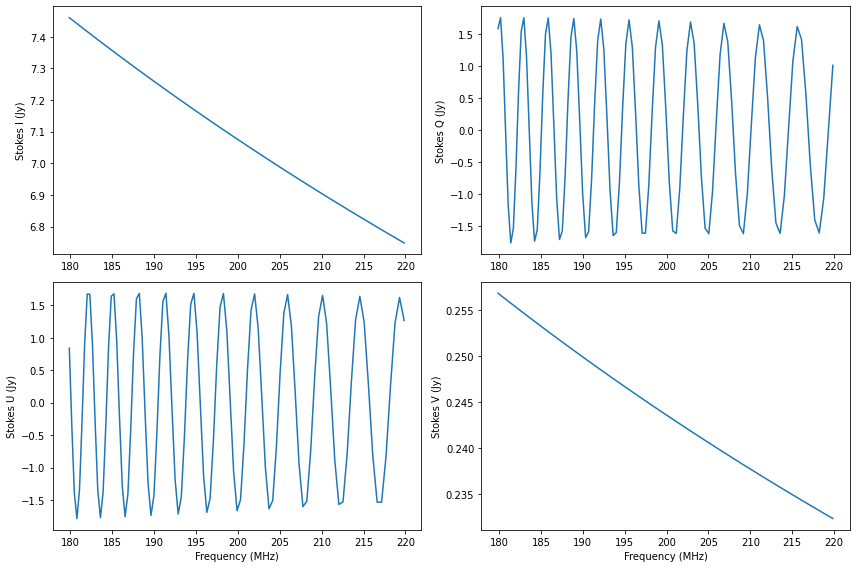

In [3]:
##This function applies Equations 9 and 10 above to derive the Q and U values
Is_Jy, Qs_Jy, Us_Jy = psaf.get_QU_complex(freqs_hz, rm, ref_I_Jy, SI, frac_pol)

##This function just applies a spectral index to extrapolate
##flux over frequencies
Vs_Jy = psaf.extrap_stokes(freqs_hz, ref_V_Jy, SI)


##Plot them up
fig, axs = plt.subplots(2,2,figsize=(12,8))

axs[0,0].plot(freqs_hz/1e+6, np.real(Is_Jy))
axs[0,1].plot(freqs_hz/1e+6, np.real(Qs_Jy))
axs[1,0].plot(freqs_hz/1e+6, np.real(Us_Jy))
axs[1,1].plot(freqs_hz/1e+6, np.real(Vs_Jy))

for ax in axs[1,:]: ax.set_xlabel('Frequency (MHz)')

labels = ['Stokes I', 'Stokes Q', 'Stokes U', 'Stokes V']

for label, ax in zip(labels, axs.flatten()): ax.set_ylabel(label + ' (Jy)')

plt.tight_layout()
# fig.savefig('PSR-J0835-4510_stokes-freq_real.png',bbox_inches='tight')
plt.show()

Sanity check our method to generate $I,Q,U,V$ to and check that the imaginary component is zero

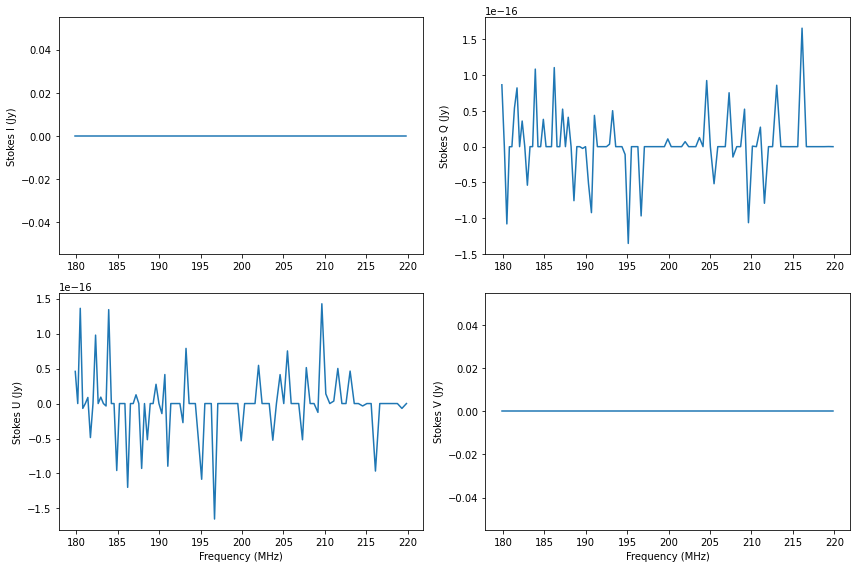

In [4]:
fig, axs = plt.subplots(2,2,figsize=(12,8))

axs[0,0].plot(freqs_hz/1e+6, np.imag(Is_Jy))
axs[0,1].plot(freqs_hz/1e+6, np.imag(Qs_Jy))
axs[1,0].plot(freqs_hz/1e+6, np.imag(Us_Jy))
axs[1,1].plot(freqs_hz/1e+6, np.imag(Vs_Jy))

for ax in axs[1,:]: ax.set_xlabel('Frequency (MHz)')

labels = ['Stokes I', 'Stokes Q', 'Stokes U', 'Stokes V']

for label, ax in zip(labels, axs.flatten()): ax.set_ylabel(label + ' (Jy)')

plt.tight_layout()
# fig.savefig('PSR-J0835-4510_stokes-freq_real.png',bbox_inches='tight')
plt.show()

Basically zero, all good.

### Jones of beam per frequency

Now calculate the FEE Jones matrix as a function of frequency using `hyperbeam`:

In [5]:
##Hyperbeam uses a environment variable to find the spherical harnmonincs,
##so set that here. You'll have to adjust this to your machine
# %env MWA_BEAM_FILE=/home/jline/software/useful/mwa_full_embedded_element_pattern.h5
%env MWA_BEAM_FILE=/home/jline/.local/lib/python3.8/site-packages/mwa_pb/data/mwa_full_embedded_element_pattern.h5

##Create the beam
beam = mwa_hyperbeam.FEEBeam()

##Point the beam at zenith
delays = [0]*16
##Container for Jones as a function of frequency
jones_per_freq = np.empty((len(freqs_hz),2,2),dtype=complex)

##Convert hour angle and declination of source into az/el using erfa
az_rad, el_rad = erfa.hd2ae(ha_rad, dec_rad, MWA_LAT_RAD)
##Convert elevaltion into zenith angle
za_rad = np.pi/2 - el_rad

##For each frequency, calculate the Jones, and shove into jones_per_freq
for ind, freq_hz in enumerate(freqs_hz):
    this_jones = beam.calc_jones(az_rad, za_rad, freq_hz, delays, [1]*16, True)

    this_jones.shape = (2,2)
    jones_per_freq[ind,:,:] = this_jones

env: MWA_BEAM_FILE=/home/jline/.local/lib/python3.8/site-packages/mwa_pb/data/mwa_full_embedded_element_pattern.h5


### Recovering RM

Now to recover the RM measure by generating the FDF. To do that we have to apply the beam to the input Stokes and given in Equations 2,3,4,5, to give instrumental `XX, XY, YX, YY` pols, and then convert those back into observerd $I,Q,U,V$ via Equations 12.

As a reminder, the FDF is recovered from $P(\lambda)$ via:

$$
\begin{equation}
F (\phi) = \int P(\lambda^2) \exp \left(-2i \phi \lambda^2\right) d\lambda^2.
\end{equation}
$$

The implementation of `np.fft` is given by (see [here](https://numpy.org/doc/stable/reference/routines.fft.html#implementation-details)):

$$
\begin{equation}
A_k = \sum^{n-1}_{m=0} a_m \exp \left(-2\pi i \frac{mk}{n} \right) \quad \quad  k = 0,...,n-1
\end{equation}
$$

In the `numpy` forward fft, the exponent has the same sign as what we want, but is scaled by `pi`, so we can use the forward transform, and will need to multiply the fft frequencies by `pi` to get the expected RM. I've added the function explicitly in the box below for your viewing pleasure.

Below, I'll try three different orderings of the polarisations:
1. The ordering straight out of FEE
2. Reversing the ordering the polarisations out of FEE
3. Reversing the ordering AND applying a sign flip to $g_{\beta\phi}, g_{\gamma\phi}$

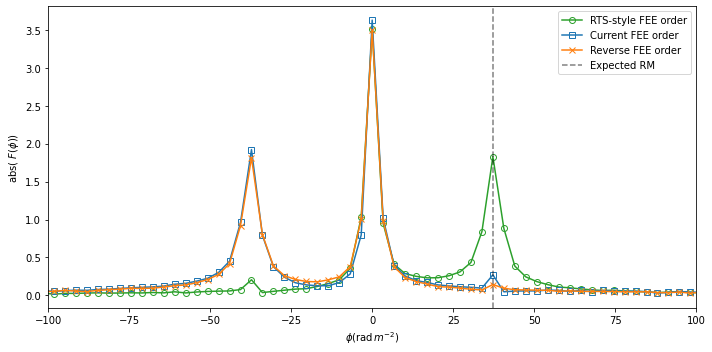

In [6]:
def recover_stokes_rm_from_jones(jones_per_freq, stokes):
    """
    Recovers observed Stokes params and Faraday Depth Function (FDF) for a
    gives Jones matrix as a function of frequency `jones_per_freq` and
    sky Stokes parameters `stokes`.
    WARNING - function assumes that the frequency sampling of
    the `jones_per_freq` is evenly space in wavelength**2. If
    not, the recovered FDF will be incorrect

    Take number a number of beam jones matrices as a function
    of freq where:
    jones_per_freq.shape = (num_freqs, 2, 2)
    and a Stokes vector of stokes = [I,Q,U,V] where:
    len(I) = len(Q) = len(U) = len(V) = num_freqs
    This function constructs the Faraday Dispersion Function by
    applying the beam Jones to the input Stokes vectors
    to create instrumental XX,XY,YX,YY instrumental pols,
    and the uses the instrumental pols calculate observed Stokes.
    Uses the observed Stokes it then calulates P = Q +iU as
    a function of wavelength. Using this it performs the necessary fourier
    transforms to calculate the FDF.

    Parameters
    ==========
    jones_per_freq : complex numpy array
        Instrumental gains to use, shape = (num_freqs, 2, 2)
    stokes : complex numpy array of length 4
        An array to represent the sky emission Stokes parameters

    Returns
    =======
    recover_stokes_per_freq : complex numpy array
        The Stokes response as see by the instrument with
        shape = (num_coords, 2, 2), where:
        stokes[:,0,0] = I
        stokes[:,0,1] = Q
        stokes[:,1,0] = U
        stokes[:,1,1] = V
    faraday_depth : numpy array
        The faraday depth values of the returned faraday rotation function `fdf`
    fdf : complex numpy array
        The FDF as calculated through from the outputs in `recover_stokes_per_freq`
    """

    ##This applies the beam jones to the input Stokes parameters, to create
    ##instrumental XX,XY,YX,YY
    inst_pols_per_freq = psaf.apply_instrumental_to_stokes(jones_per_freq, stokes)

    ##Takes the generated XX, XY, YX, YY to recover the Stokes pols
    recover_stokes_per_freq = psaf.convert_inst_back_to_stokes(inst_pols_per_freq)
    recovered_Q = recover_stokes_per_freq[:,0,1]
    recovered_U = recover_stokes_per_freq[:,1,0]

    ##P = Q + iU
    P_per_lambda_sqr = recovered_Q + 1j*recovered_U

    ##FDF is the fourier transform of P
    fdf = np.fft.fftshift(np.fft.fft(P_per_lambda_sqr))

    ##Get resolution of the wavelengths
    wave_sqr_res = wavelens_squared[1] - wavelens_squared[0]
    ##numpy definition of ft frequencies is off by pi compared to FDF def
    faraday_depth = np.pi*np.fft.fftshift(np.fft.fftfreq(len(wavelens_squared),wave_sqr_res))

    return recover_stokes_per_freq, faraday_depth, fdf


##Combine the stokes of our source that we generated into one array
stokes = np.array([Is_Jy, Qs_Jy, Us_Jy, Vs_Jy])


###===========Use FEE pol ordering as is==============================================================
##Rotate the Jones matrix about parallactic angle to get out of phi/theta polarisations
rotated_jones_per_freq = psaf.rotate_jones_para(ha_rad, dec_rad, jones_per_freq)
##Apply Jones to stokes params and get the FDF
recover_stokes_per_freq, faraday_depth, fdf = recover_stokes_rm_from_jones(rotated_jones_per_freq, stokes)

##You can achieve the same result for RM without rotating about parallactic angle, just
##comment out the two lines above to switch it off
# recover_stokes_per_freq, faraday_depth, fdf = recover_stokes_rm_from_jones(jones_per_freq, stokes)
###===================================================================================================



###===========Just reverse FEE pol ordering===========================================================
reverse_jones_per_freq = np.empty((len(freqs_hz),2,2),dtype=complex)

reverse_jones_per_freq[:,0,0] =  jones_per_freq[:,1,1]
reverse_jones_per_freq[:,0,1] =  jones_per_freq[:,1,0]
reverse_jones_per_freq[:,1,0] =  jones_per_freq[:,0,1]
reverse_jones_per_freq[:,1,1] =  jones_per_freq[:,0,0]

rotated_reverse_jones_per_freq = psaf.rotate_jones_para(ha_rad, dec_rad, reverse_jones_per_freq)
recover_reverse_stokes_per_freq, reverse_faraday_depth, reverse_fdf = recover_stokes_rm_from_jones(rotated_reverse_jones_per_freq, stokes)
# recover_reverse_stokes_per_freq, reverse_faraday_depth, reverse_fdf = recover_stokes_rm_from_jones(reverse_jones_per_freq, stokes)
###===================================================================================================



###===========Apply rts pol ordering and flip=========================================================
rts_jones_per_freq = np.empty((len(freqs_hz),2,2),dtype=complex)

rts_jones_per_freq[:,0,0] =  -jones_per_freq[:,1,1]
rts_jones_per_freq[:,0,1] =  jones_per_freq[:,1,0]
rts_jones_per_freq[:,1,0] =  -jones_per_freq[:,0,1]
rts_jones_per_freq[:,1,1] =  jones_per_freq[:,0,0]

rotated_rts_jones_per_freq = psaf.rotate_jones_para(ha_rad, dec_rad, rts_jones_per_freq)
recover_rts_stokes_per_freq, rts_faraday_depth, rts_fdf = recover_stokes_rm_from_jones(rotated_rts_jones_per_freq, stokes)
# recover_rts_stokes_per_freq, rts_faraday_depth, rts_fdf = recover_stokes_rm_from_jones(rts_jones_per_freq, stokes)
###===================================================================================================


##Plot em up
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(faraday_depth, abs(rts_fdf), 'C2o-' ,mfc='none', label='RTS-style FEE order')
ax.plot(faraday_depth, abs(fdf), 'C0s-',mfc='none', label='Current FEE order')
ax.plot(faraday_depth, abs(reverse_fdf), 'C1x-' ,mfc='none', label='Reverse FEE order')
                                                                                                   

ax.set_ylabel('abs( $F(\phi) $)')
ax.set_xlabel('$\phi ( \mathrm{rad} \, m^{-2}$)')

ax.axvline(rm,color='k',label='Expected RM',alpha=0.5, linestyle='--')

ax.set_xlim(-100,100)

ax.legend()

plt.tight_layout()
# fig.savefig('recover_rm_comparison.png',bbox_inches='tight')
plt.show()

The peak at $\phi=0$ always happens due to beam leakage to my understanding, and is akin to a synthesized psf in image space. We see that only the RTS-style pol and sign flip produces the expected sign of RM, which should be positive. Just flipping the ordering of the pols doesn't change anything.

If we repeat the process with the RTS analytic beam:

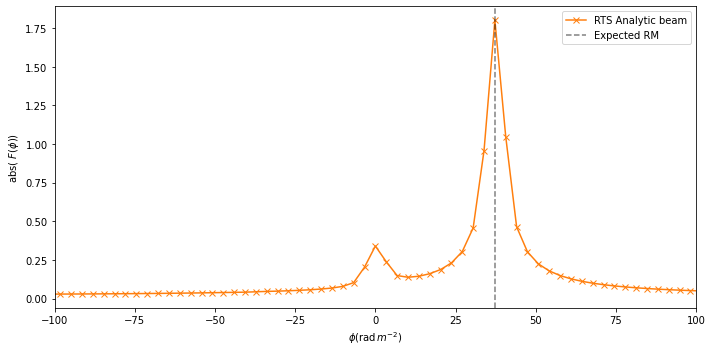

In [7]:
from rts_analytic_beam import RTS_analytic_beam

##Container for Jones as a function of frequency
rtsbeam_jones_per_freq = np.empty((len(freqs_hz),2,2),dtype=complex)

##For each frequency, calculate the Jones, and shove into jones_per_freq
for ind, freq_hz in enumerate(freqs_hz):
    ##Beam calculation, via RTS analytic beam code
    this_jones = RTS_analytic_beam(az_rad, za_rad,  delays, freq_hz, norm=True)

    this_jones.shape = (2,2)
    rtsbeam_jones_per_freq[ind,:,:] = this_jones


##Calculate the observed Stokes and FDF
rtsbeam_stokes_per_freq, rtsbeam_faraday_depth, rtsbeam_fdf = recover_stokes_rm_from_jones(rtsbeam_jones_per_freq, stokes)
    
##Plot em up
fig, ax = plt.subplots(1,1, figsize=(10,5))

ax.plot(rtsbeam_faraday_depth, abs(rtsbeam_fdf), 'C1x-' ,mfc='none', label='RTS Analytic beam')

##You can compare to the reordered FEE beam by uncommenting this bit
# ax.plot(faraday_depth, abs(rts_fdf), 'C0o-' ,mfc='none', label='RTS-style FEE order')
                                                                                                   
ax.set_ylabel('abs( $F(\phi) $)')
ax.set_xlabel('$\phi ( \mathrm{rad} \, m^{-2}$)')

ax.axvline(rm,color='k',label='Expected RM',alpha=0.5, linestyle='--')

ax.set_xlim(-100,100)
ax.legend()

plt.tight_layout()
plt.show()

I think I'm right in saying that as the analytic beam is entirely real and contains no mutual coupling, the modelling leakage is far smaller, hence the reduced peak at $\phi=0$. We again see the peak at the correct positive RM.

# Beam across the full sky
Here I'll look into the beam response across the entire sky, and try to nail down the necessary rotations and sign flips. I'm going to try and set the frame up in 'astronomer coordinates' first, e.g. something celestial, so I'll setup an RA/Dec frame and then convert to az/za as defined in the `pyerfa` package. This has it's roots in SOFA, which was endorsed/published by the IAU, so I'm sticking with these transforms as sensible.

/home/jline/.local/lib/python3.8/site-packages/erfa/core.py:17402: RuntimeWarning: invalid value encountered in hd2ae
  az, el = ufunc.hd2ae(ha, dec, phi)
<ipython-input-8-cd9c34cb3c70>:62: RuntimeWarning: invalid value encountered in greater
  below_horizon = np.where(za_grid > np.pi/2)


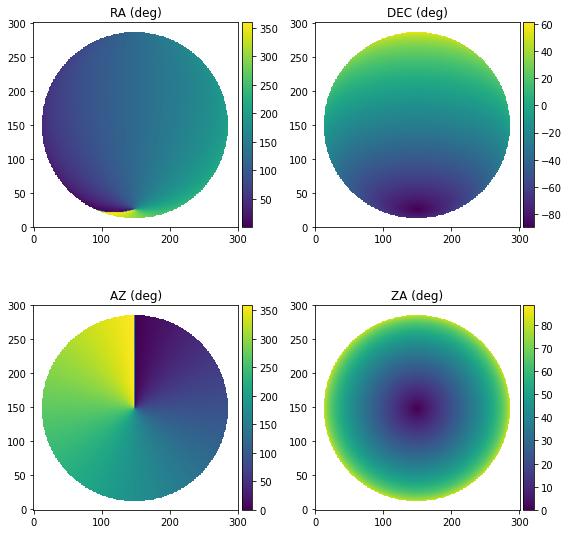

In [8]:
from astropy.io import fits
import numpy as np
from astropy.wcs import WCS
from copy import deepcopy

nside = 301

lst_deg = lst_rad / D2R

##Setup a dummy FITS header with appropriate settings
header = fits.Header()

##Give it 301 pixel for each axis
nside = 301

##This resolution seems to cover the full sky nicely
cpix = int(nside // 2)
cdelt = 0.25
cdelt = 125 / nside

header['NAXIS']   = 2
header['NAXIS1']  = nside
header['NAXIS2']  = nside
header['CTYPE1']  = 'RA---SIN'
header['CRPIX1']  = cpix
header['CRVAL1']  = lst_deg
header['CDELT1']  = cdelt
header['CUNIT1']  = 'deg     '
header['CTYPE2']  = 'DEC--SIN'
header['CRPIX2']  = cpix
header['CRVAL2']  = MWA_LAT
header['CDELT2']  = cdelt
header['CUNIT2']  = 'deg     '

##Make a world coord system
wcs = WCS(header)

##Set up x/y pixels that cover the whole image
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))

x_pixels = x_mesh.flatten()
y_pixels = y_mesh.flatten()

##convert to ra, dec
ras, decs = wcs.all_pix2world(x_pixels, y_pixels, 0.0)

##Then use erfa to convert these values into azs, els
has = lst_deg - ras

##use this erfa function to convert to azimuth and elevation
##were using degrees, but erfa uses rads, so convert here
az_grid, els = erfa.hd2ae(has*D2R, decs*D2R, MWA_LAT_RAD);

##convert elevation to zenith angle
za_grid = np.pi/2 - els

za_grid.shape = (nside,nside)
az_grid.shape = (nside,nside)


##Mask below horizon for better plots
below_horizon = np.where(za_grid > np.pi/2)
az_grid[below_horizon] = np.nan
za_grid[below_horizon] = np.nan


##Do some fiddling for plotting reasons
ras_plot = deepcopy(ras)
decs_plot = deepcopy(decs)
azs_plot = az_grid.flatten() / D2R
zas_plot = za_grid.flatten() / D2R

fig, axs = plt.subplots(2,2,figsize=(8,8))

arr_plots = [ras_plot, decs_plot, azs_plot, zas_plot]
labels = ['RA (deg)', 'DEC (deg)', 'AZ (deg)', 'ZA (deg)']

for arr, ax, label in zip(arr_plots, axs.flatten(),labels):
    arr.shape = (nside,nside)
    im = ax.imshow(arr,origin='lower')
    
    ax.set_title(label)
    
    psaf.add_colourbar(ax=ax, im=im, fig=fig)
    
plt.tight_layout()
plt.show()

### RTS zenith pointing Jones on sky
First of all, let's see what the RTS analytic jones matrix, which is generated natively to be aligned with the celestial sphere, looks like upon the sky:

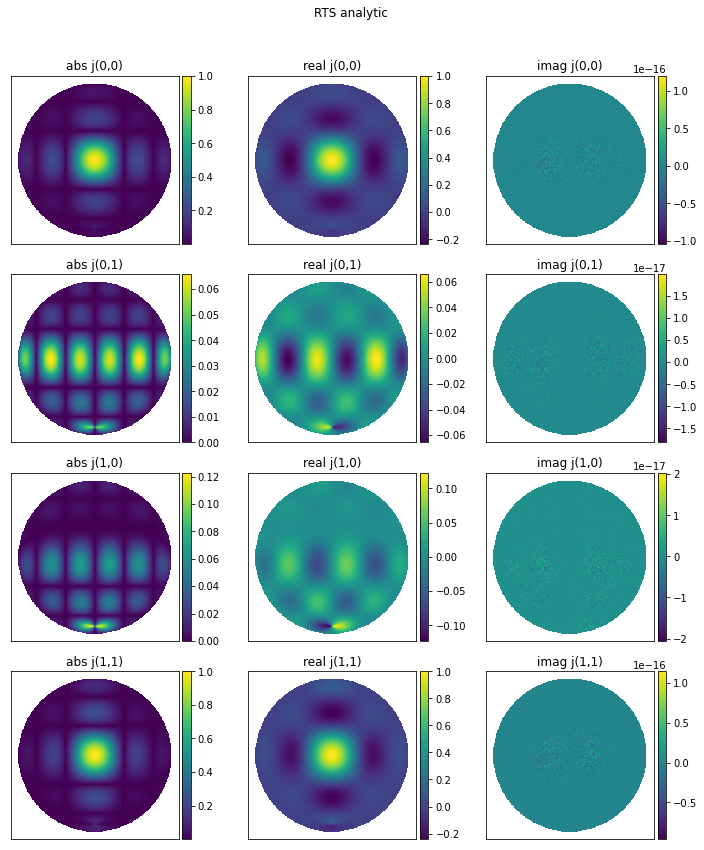

In [9]:
freq_hz = 180e+6
delays = np.zeros(16)

##Container for Jones as a function of frequency
rtsbeam_jones_sky = np.empty((len(az_grid.flatten()),2,2),dtype=complex)

##I can't be bothered to vectorise the RTS beam so just loop, not too slow
##takes about 1 minute on my desktop
ind = 0
for az_rad, za_rad in zip(az_grid.flatten(), za_grid.flatten()):
    this_jones = RTS_analytic_beam(az_rad, za_rad,  delays, freq_hz, norm=True)
    
    this_jones.shape = (2,2)
    rtsbeam_jones_sky[ind,:,:] = this_jones
    ind += 1
    
##I've pulled the plotting functions into polarised_source_and_FEE.py
psaf.plot_jones_matrix(az_grid.shape, rtsbeam_jones_sky, 'RTS analytic')

We can turn this into XX, XY, YX, YY for a purely Stokes I sky:

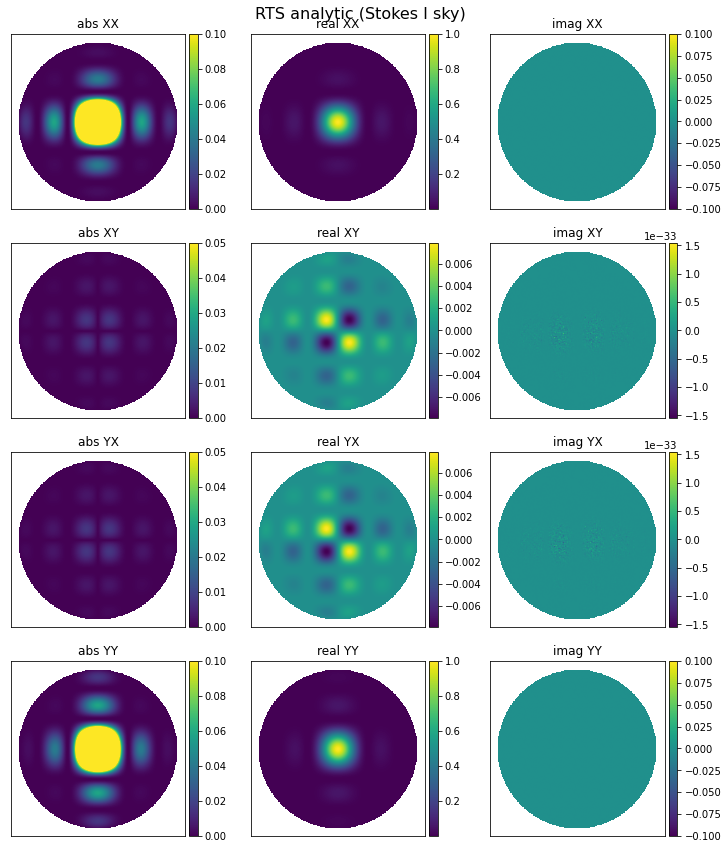

In [10]:
##Make a 'Stokes vector' of [I,Q,U,V] - again being lazy, made it complex
##Set I to 1.0 + 0.0j and everything else to zero
stokesI = [complex(1,0),complex(0,0),complex(0,0),complex(0,0)]

##This applies equaitons 2,3,4,5 above
inst_pols_rts_beam = psaf.apply_instrumental_to_stokes(rtsbeam_jones_sky, stokesI)

##Plot 'em up
psaf.plot_inst_pols(az_grid.shape, inst_pols_rts_beam, 'RTS analytic (Stokes I sky)', vmins=[0,0,0,0], vmaxs=[0.1, 0.05, 0.05, 0.1])

Here I've fiddled with the plotting scales on the absolute to emphasize the sidelobes. A dipole oriented along north-south see nulls towards the north and south, and so we expect the sidelobe response to be weaker in towards north and south. This is what we see for the XX beam here, which as defined earlier in the notebook, I'm calling the north-south aligned dipole.

## FEE beam out of `hyperbeam`
Without any rotations or modification, let's look at the FEE beam on the sky:


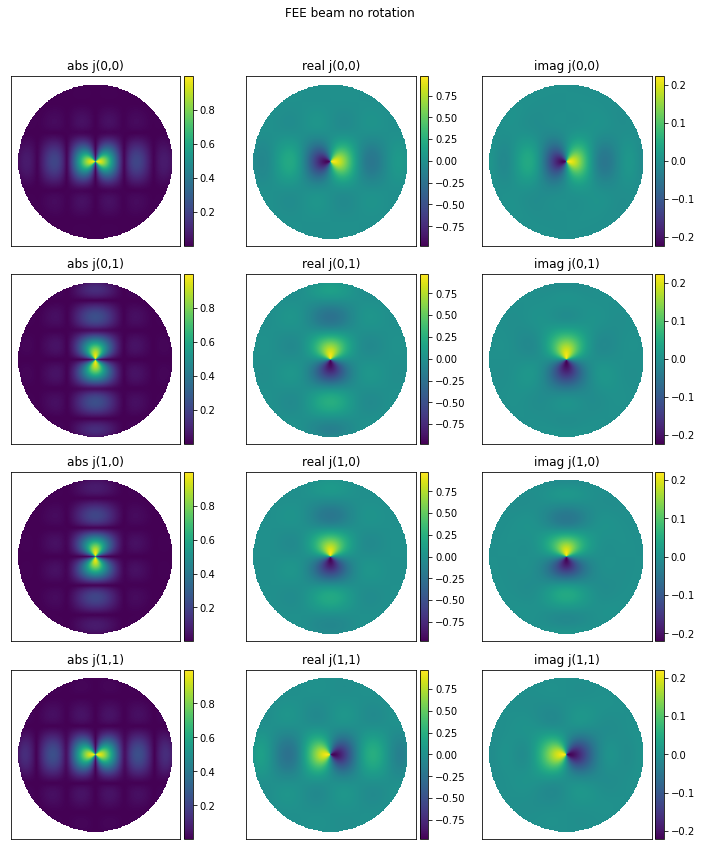

In [11]:
##New hyperbeam beam
beam = mwa_hyperbeam.FEEBeam()

freq = 180e+6
delays = [0]*16

##Calculate some valllueees
fee_jones_sky = beam.calc_jones_array(az_grid.flatten(), za_grid.flatten(), freq, delays, [1]*16, True)

##I've defined all my plotting stuff for 2x2 jones matrices (long story) so reshape
fee_jones_sky = psaf.remap_hbeam_jones(fee_jones_sky)

##Plot times
psaf.plot_jones_matrix(az_grid.shape, fee_jones_sky, 'FEE beam no rotation')

Of course this looks totally different to RTS analytic, as it's in the $\theta, \phi$ pols discussed in the intro, and needs to be rotated. Let's rotate it and plot again.

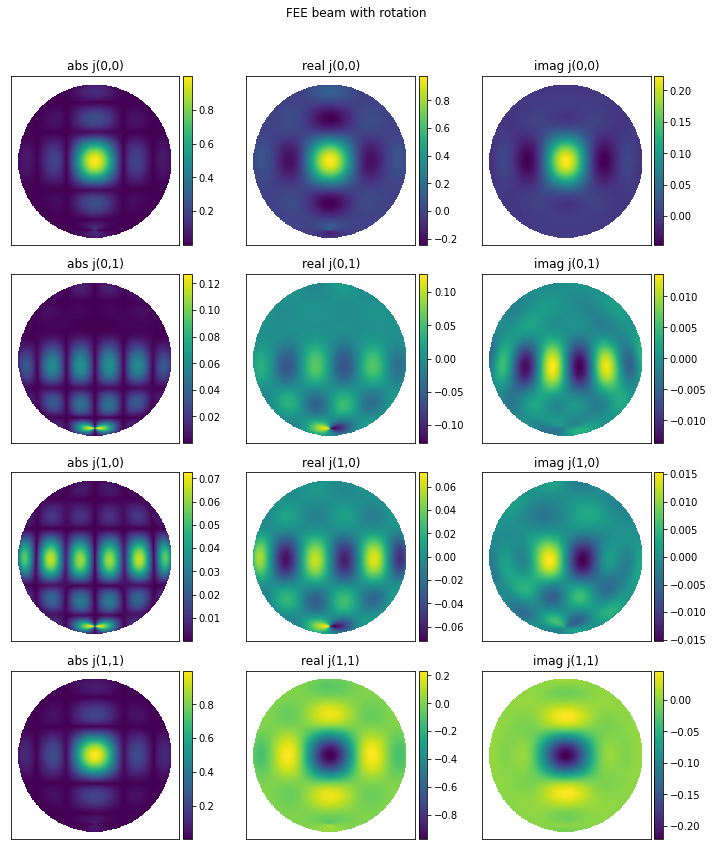

In [12]:
##Use erfa to get ha, dec for each az,za at the MWA latitude
has_rad, decs_rad = erfa.ae2hd(az_grid.flatten(), np.pi/2 - za_grid.flatten(), MWA_LAT_RAD)

##This function applies to rotation detailed in Equations 1 in the intro
##The funciton uses erfa to calculate parallactic angle
##I've explicitly added the pi/2 offset as an argument so you can experiment with
##rotations if desired
rot_fee_jones_sky = psaf.rotate_jones_para(has_rad, decs_rad, fee_jones_sky, para_angle_offset=np.pi/2)

##Plots are life
psaf.plot_jones_matrix(az_grid.shape, rot_fee_jones_sky, 'FEE beam with rotation')

This looks far more similar to the RTS analytic beam, and if we convert to intrumetal polarisations for a Stokes I sky:

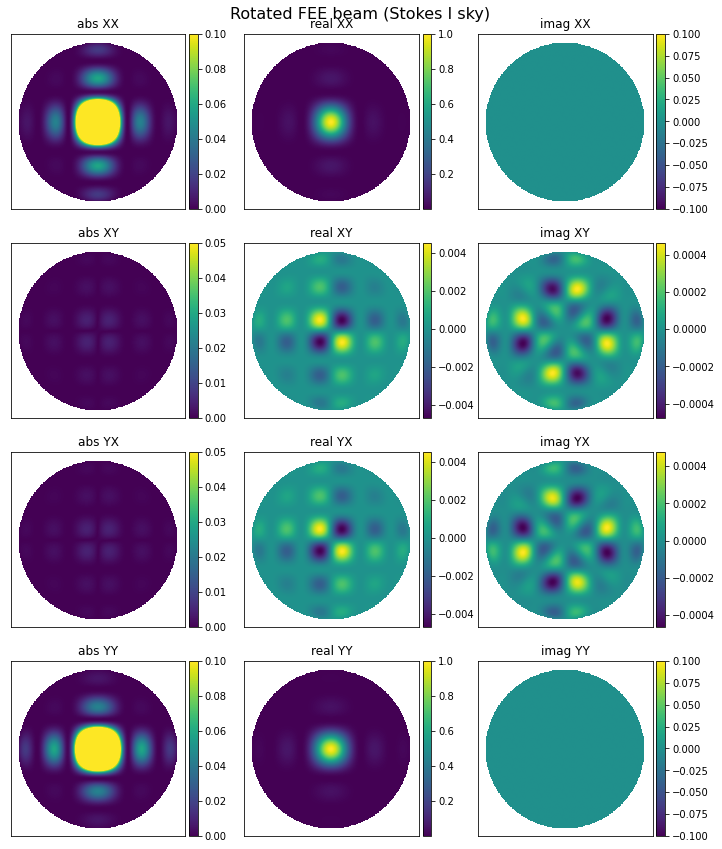

In [13]:
rot_fee_jones_sky = psaf.rotate_jones_para(has_rad, decs_rad, fee_jones_sky, para_angle_offset=np.pi/2)

inst_pols_rot_fee = psaf.apply_instrumental_to_stokes(rot_fee_jones_sky, stokesI)

psaf.plot_inst_pols(az_grid.shape, inst_pols_rot_fee, 'Rotated FEE beam (Stokes I sky)', vmins=[0,0,0,0], vmaxs=[0.1, 0.05, 0.05, 0.1])

We get something extremely similar, albeit XX is now more senstive to emission in the north and south, which suggests that XX now corresponds to a dipole which is aligned to the east-south. That is fixed easily by changing the order of the jones matrix:

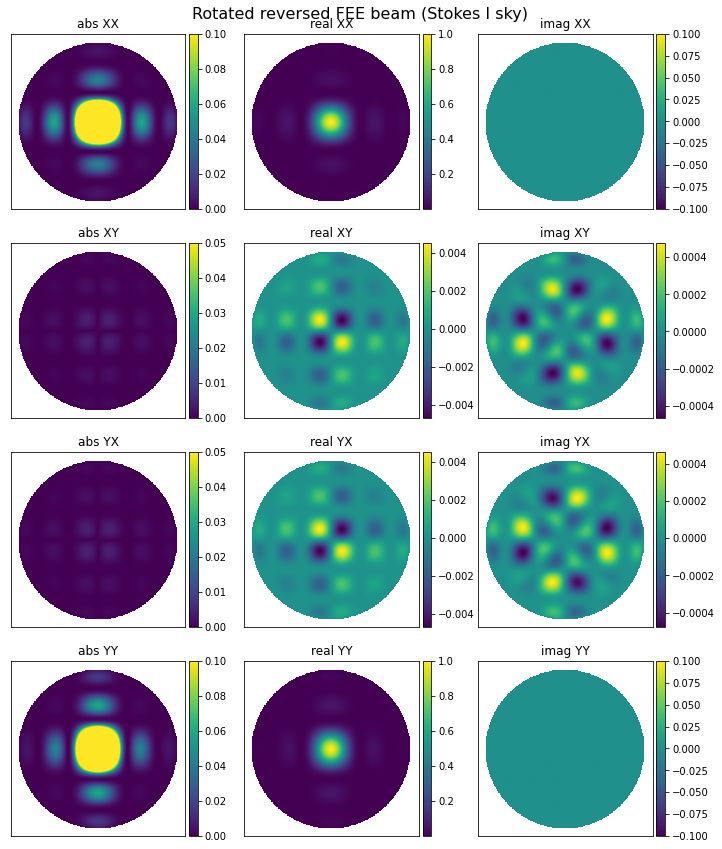

In [14]:
##Make a an empty container
reverse_fee_jones_sky = np.empty(fee_jones_sky.shape,dtype=complex)

##Explicitly flip positions in the 2x2 Jones
reverse_fee_jones_sky[:,0,0] = fee_jones_sky[:,1,1]
reverse_fee_jones_sky[:,0,1] = fee_jones_sky[:,1,0]
reverse_fee_jones_sky[:,1,0] = fee_jones_sky[:,0,1]
reverse_fee_jones_sky[:,1,1] = fee_jones_sky[:,0,0]

##Rotate about parallactic angle + pi/2
rot_rev_fee_jones_sky = psaf.rotate_jones_para(has_rad, decs_rad, reverse_fee_jones_sky, para_angle_offset=np.pi/2)

##Apply to a Stokes I sky
inst_pols_rot_rev_fee = psaf.apply_instrumental_to_stokes(rot_rev_fee_jones_sky, stokesI)

##Plot
psaf.plot_inst_pols(az_grid.shape, inst_pols_rot_rev_fee, 'Rotated reversed FEE beam (Stokes I sky)', vmins=[0,0,0,0], vmaxs=[0.1, 0.05, 0.05, 0.1])

## Polarised skies
In the above, we've only considered a Stokes I sky. What happens with polarised skies? First off, let's start with the RTS analytic beam. Let's generate instrumental pols for a Stokes U sky:

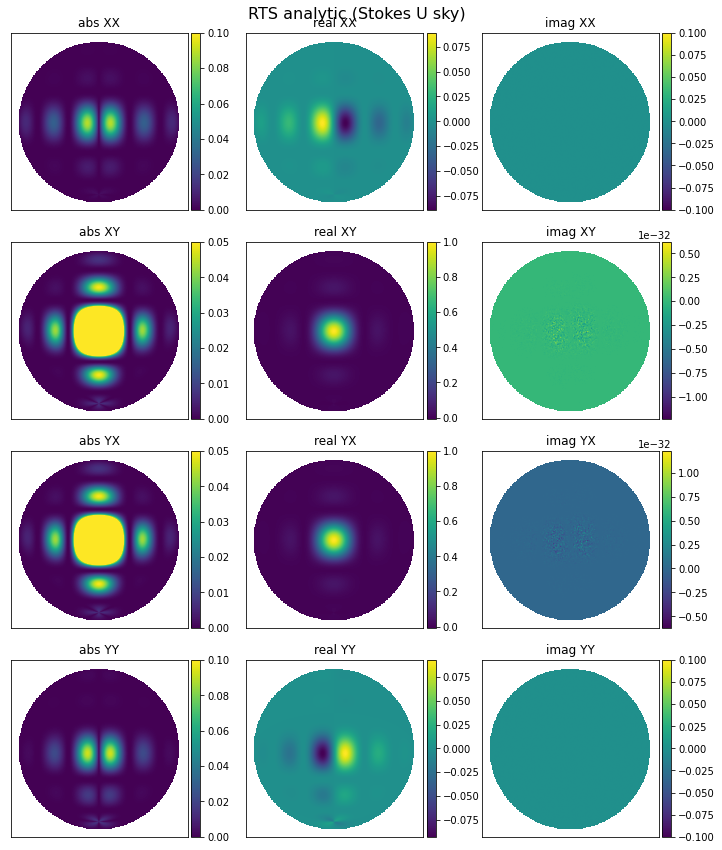

In [15]:
##Again, vector of [I,Q,U,V]
stokesU = [complex(0,0),complex(0,0),complex(1,0),complex(0,0)]

inst_pols_rts_beam_U = psaf.apply_instrumental_to_stokes(rtsbeam_jones_sky, stokesU)

psaf.plot_inst_pols(az_grid.shape, inst_pols_rts_beam_U, 'RTS analytic (Stokes U sky)', vmins=[0,0,0,0], vmaxs=[0.1, 0.05, 0.05, 0.1])

We can then combine the intrumental pols to recovered the sky in Stokes paramaters via Equations 12 above:

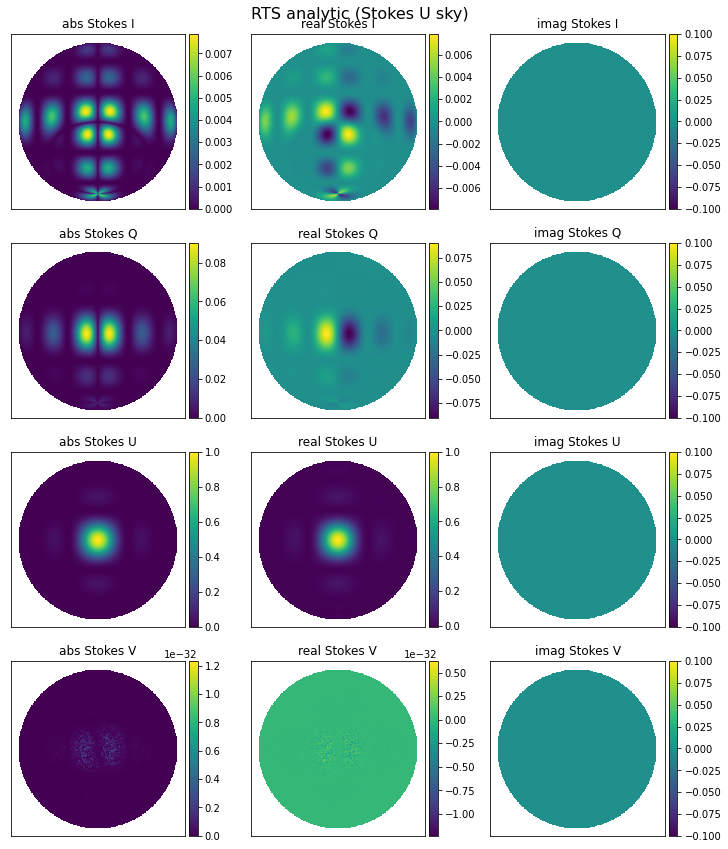

In [16]:
##Applies Equation 12
beam_stokes_rts_beam_U = psaf.convert_inst_back_to_stokes(inst_pols_rts_beam_U)

vmins = [0, 0, 0, 0]
vmaxs = [0.008, 0.09, 0.1, 1e-10]

psaf.plot_stokes_beam(az_grid.shape, beam_stokes_rts_beam_U, 'RTS analytic (Stokes U sky)')

So we can see some leakage into Stokes Q (and maybe a little into I), but we basically recover a positive real U response.

## FEE beam U response
Ok, so we saw that for the equations as defined above, we have to reverse the order of polarisations of the FEE beam. Let's make a Stokes U beam for the reversed FEE beam:

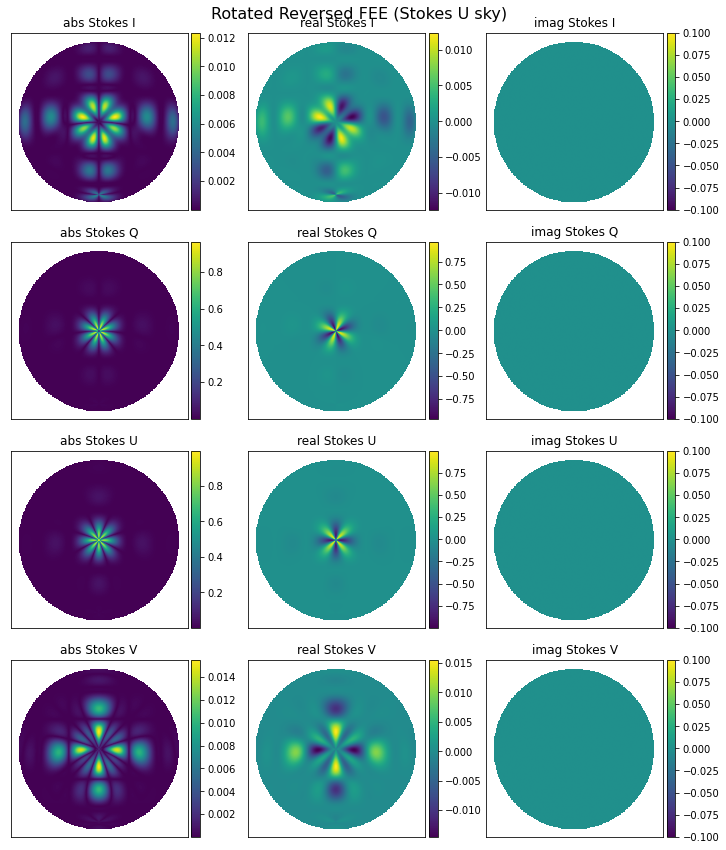

In [17]:
##Already have made a rotated, reversed FEE Jones matrix, so just apply a Stokes Q sky
inst_pols_rot_rev_fee_U = psaf.apply_instrumental_to_stokes(rot_rev_fee_jones_sky, stokesU)

##Applies Equations 12 to recover observed Stokes params
beam_stokes_rot_rev_fee_U = psaf.convert_inst_back_to_stokes(inst_pols_rot_rev_fee_U)

##Do plot
psaf.plot_stokes_beam(az_grid.shape, beam_stokes_rot_rev_fee_U, 'Rotated Reversed FEE (Stokes U sky)')

Well that just looks insane. Let's try it on jones that has only been rotated and not reversed in order:

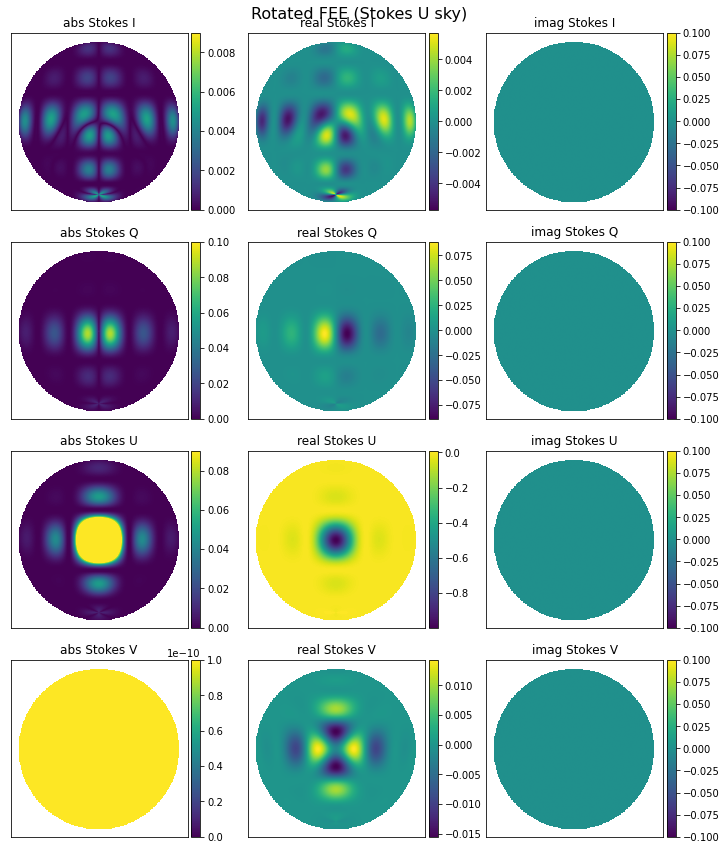

In [18]:
inst_pols_rot_fee_U = psaf.apply_instrumental_to_stokes(rot_fee_jones_sky, stokesU)

beam_stokes_rot_fee_U = psaf.convert_inst_back_to_stokes(inst_pols_rot_fee_U)

vmins = [0, 0, 0, 0]
vmaxs = [0.009, 0.1, 0.09, 1e-10]

psaf.plot_stokes_beam(az_grid.shape, beam_stokes_rot_fee_U, 'Rotated FEE (Stokes U sky)', vmins=vmins, vmaxs=vmaxs)

Ok, this looks better, but Stokes U is negative in the real, instead of positive. Perhaps if we just stick with the current FEE pol ordering, we can somehow modify the Equations (12) above to get the correct result. But these definitions are in the textbook, and are used by `WSClean`, which I think is an industry standard imager. You _can_ get the correct result when reordering, by adding a negative on the $g_{\beta\phi}, g_{\gamma\phi}$ as we did before in the RM analysis. As I said above, I think the sign-flip is necessary due to $\phi$ going in the opposite direction to `az`, but other offered explanations for this sign flip include (but are not limited to) the FEKO package was run with an emitting antenna instead of a recieving antenna and the rotation angle of electric field defintion inside FEKO not aligning the defintions above.

Let's do the flippy flip.

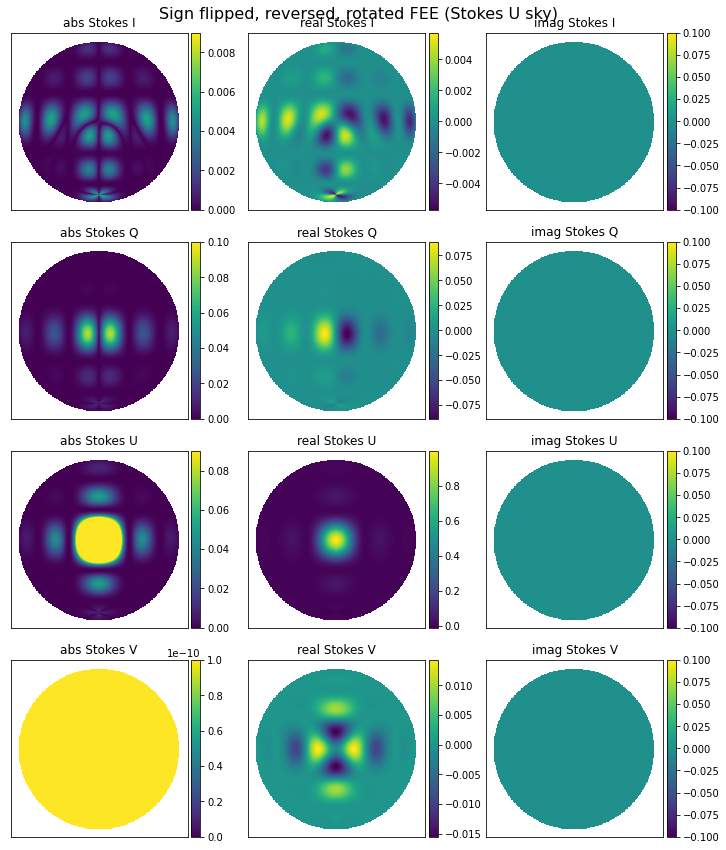

In [19]:
revflip_fee_jones_sky = np.empty(fee_jones_sky.shape,dtype=complex)

revflip_fee_jones_sky[:,0,0] = -fee_jones_sky[:,1,1]
revflip_fee_jones_sky[:,0,1] = fee_jones_sky[:,1,0]
revflip_fee_jones_sky[:,1,0] = -fee_jones_sky[:,0,1]
revflip_fee_jones_sky[:,1,1] = fee_jones_sky[:,0,0]

rot_revflip_fee_jones_sky = psaf.rotate_jones_para(has_rad, decs_rad, revflip_fee_jones_sky, para_angle_offset=np.pi/2)

inst_pols_rot_revflip_fee_U = psaf.apply_instrumental_to_stokes(rot_revflip_fee_jones_sky, stokesU)

beam_stokes_rot_revflip_fee_U = psaf.convert_inst_back_to_stokes(inst_pols_rot_revflip_fee_U)

vmins = [0, 0, 0, 0]
vmaxs = [0.009, 0.1, 0.09, 1e-10]

psaf.plot_stokes_beam(az_grid.shape, beam_stokes_rot_revflip_fee_U, 'Sign flipped, reversed, rotated FEE (Stokes U sky)', vmins=vmins, vmaxs=vmaxs)

Et viola, we know have a positive Stokes U. You can repeat this procedue for all the Stokes params, and return back the expected sign each time (see below). I have played around with sticking in negative azmiuth values, adding in azmiuth offsets, changing the rotation value offset, and combinations of all those things, but the only thing that I've found that is capable of returning the expected Stokes params to be the $\varphi = q + \pi/2$ rotation, and reversing the pols + flipping the signs on the $\phi$ pol gains.

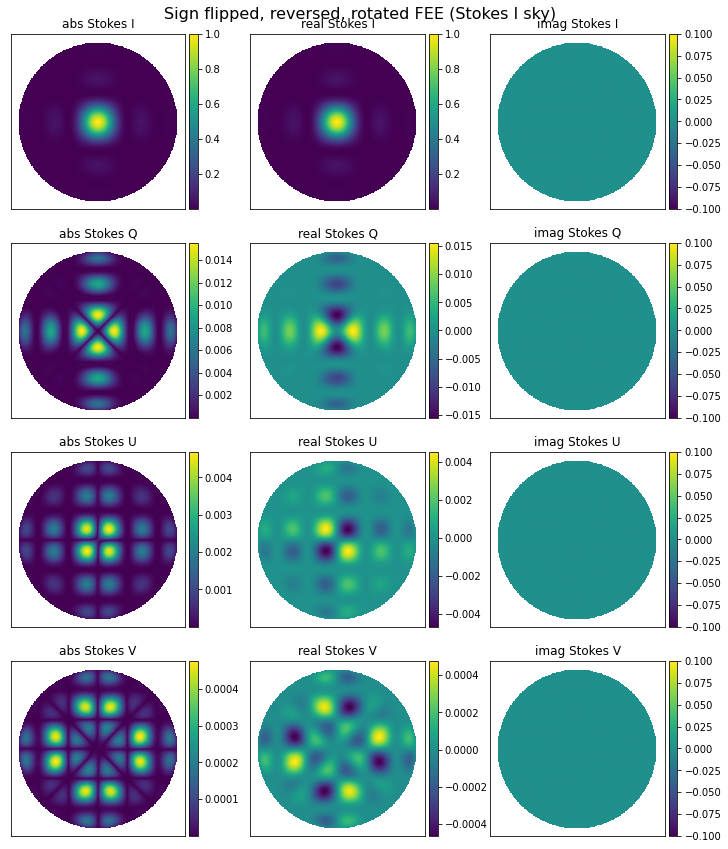

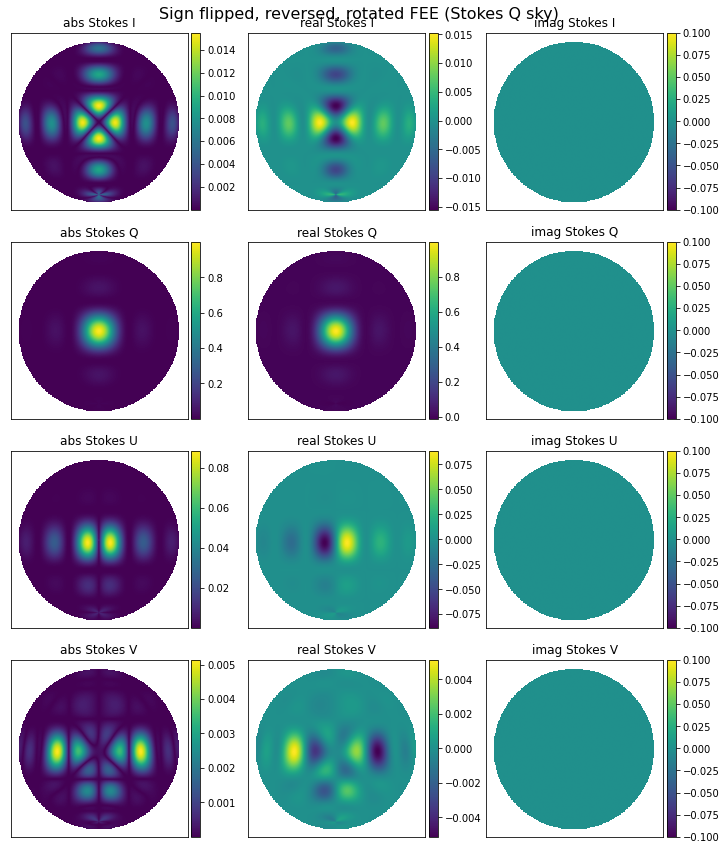

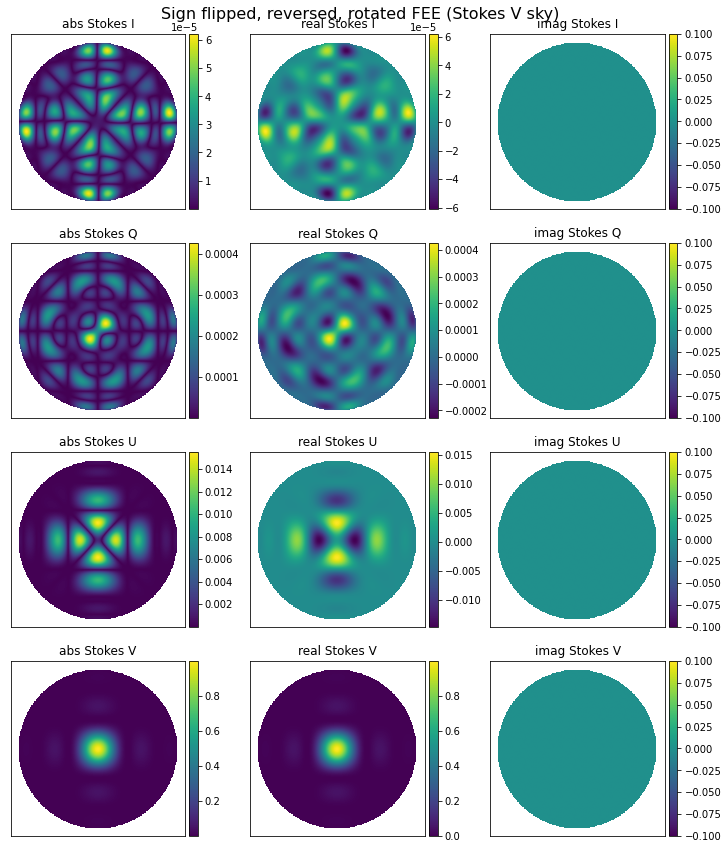

In [20]:
stokesQ = [complex(0,0), complex(1,0), complex(0,0), complex(0,0)]
stokesV = [complex(0,0), complex(0,0), complex(0,0), complex(1,0)]

##Stokes I========================================================================================================
inst_pols_rot_revflip_fee_I = psaf.apply_instrumental_to_stokes(rot_revflip_fee_jones_sky, stokesI)
beam_stokes_rot_revflip_fee_I = psaf.convert_inst_back_to_stokes(inst_pols_rot_revflip_fee_I)
psaf.plot_stokes_beam(az_grid.shape, beam_stokes_rot_revflip_fee_I, 'Sign flipped, reversed, rotated FEE (Stokes I sky)')

##Stokes Q========================================================================================================
inst_pols_rot_revflip_fee_Q = psaf.apply_instrumental_to_stokes(rot_revflip_fee_jones_sky, stokesQ)
beam_stokes_rot_revflip_fee_Q = psaf.convert_inst_back_to_stokes(inst_pols_rot_revflip_fee_Q)
psaf.plot_stokes_beam(az_grid.shape, beam_stokes_rot_revflip_fee_Q, 'Sign flipped, reversed, rotated FEE (Stokes Q sky)')

##Stokes V========================================================================================================
inst_pols_rot_revflip_fee_V = psaf.apply_instrumental_to_stokes(rot_revflip_fee_jones_sky, stokesV)
beam_stokes_rot_revflip_fee_V = psaf.convert_inst_back_to_stokes(inst_pols_rot_revflip_fee_V)
psaf.plot_stokes_beam(az_grid.shape, beam_stokes_rot_revflip_fee_V, 'Sign flipped, reversed, rotated FEE (Stokes V sky)')

# Are we pointing in the right direction with the given az/za??
The final thing to test is that for an off-zenith observation, that we actually point to the RA/Dec that we expect, and that matches the az/za we have given. For this, I'm going to assume that the values reported in the metafits are the truth, and that the coord conversions inside `erfa` are correct.

I'm going to use the observational settings from `1094838496_metafits_ppds.fits`. These are:

```
LST =  18.28327172083333
RA =  2.809605784156231
DEC =  -25.96905805885287
DELAYS =  6,4,2,0,6,4,2,0,6,4,2,0,6,4,2,0
```

Setup the sky up again with the new lst:

In [21]:
lst = 18.28327172083333

##Setup a dummy FITS header with appropriate settings
header = fits.Header()

##Give it 301 pixel for each axis
nside = 301

##This resolution seems to cover the full sky nicely
cpix = int(nside // 2)
cdelt = 0.25
cdelt = 125 / nside

header['NAXIS']   = 2
header['NAXIS1']  = nside
header['NAXIS2']  = nside
header['CTYPE1']  = 'RA---SIN'
header['CRPIX1']  = cpix
header['CRVAL1']  = lst
header['CDELT1']  = cdelt
header['CUNIT1']  = 'deg     '
header['CTYPE2']  = 'DEC--SIN'
header['CRPIX2']  = cpix
header['CRVAL2']  = MWA_LAT
header['CDELT2']  = cdelt
header['CUNIT2']  = 'deg     '

##Make a world coord system
wcs = WCS(header)

##Set up x/y pixels that cover the whole image
x_mesh, y_mesh = np.meshgrid(np.arange(nside), np.arange(nside))

x_pixels = x_mesh.flatten()
y_pixels = y_mesh.flatten()

ras, decs = wcs.all_pix2world(x_pixels, y_pixels, 0.0)

##Then use erfa to convert these values into azs, els
has = lst - ras

##use this erfa function to convert to azimuth and elevation
##were using degrees, but erfa uses rads, so convert here
azs, els = erfa.hd2ae( has*D2R, decs*D2R, MWA_LAT_RAD);

##convert elevation to zenith angle
zas = np.pi/2 - els

Let's plot the coordinate systems on the sky:

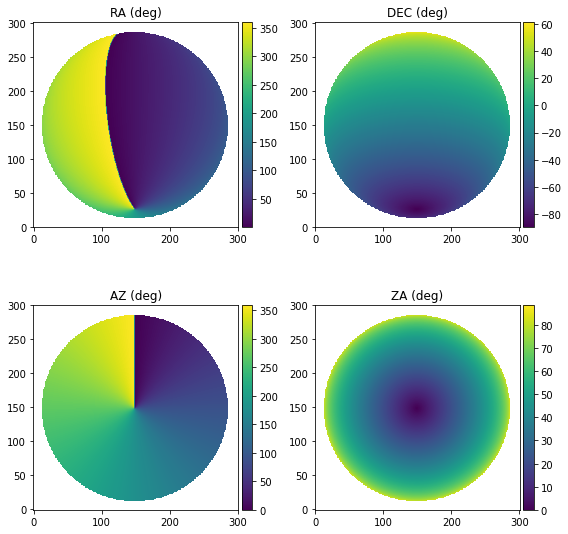

In [22]:
from copy import deepcopy

ras_plot = deepcopy(ras)
decs_plot = deepcopy(decs)
azs_plot = azs / D2R
zas_plot = zas / D2R

fig, axs = plt.subplots(2,2,figsize=(8,8))

arr_plots = [ras_plot, decs_plot, azs_plot, zas_plot]
labels = ['RA (deg)', 'DEC (deg)', 'AZ (deg)', 'ZA (deg)']

for arr, ax, label in zip(arr_plots, axs.flatten(),labels):
    arr.shape = (nside,nside)
    im = ax.imshow(arr,origin='lower')
    
    ax.set_title(label)
    
    psaf.add_colourbar(ax=ax, im=im, fig=fig)
    
plt.tight_layout()
plt.show()

Right, let's generate the beam jones matrix, do our rotations and what not, and plot the expected pointing centre over the top as an orange circle

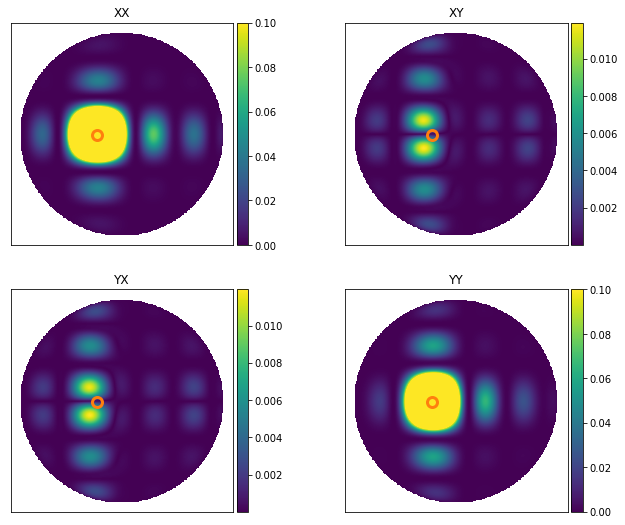

In [23]:
##Generate the jones matrix 
beam = mwa_hyperbeam.FEEBeam()

delays = np.array([6,4,2,0,6,4,2,0,6,4,2,0,6,4,2,0])

jones = beam.calc_jones_array(azs, zas, 180e6, delays, [1]*16, True)
jones = psaf.remap_hbeam_jones(jones)

##Apply reordering/sign flip
fiddle_jones = np.empty(jones.shape,dtype=complex)

fiddle_jones[:,0,0] = -jones[:,1,1]
fiddle_jones[:,0,1] = jones[:,1,0]
fiddle_jones[:,1,0] = -jones[:,0,1]
fiddle_jones[:,1,1] = jones[:,0,0]

##Rotate into celestial frame
rot_fiddle_jones = psaf.rotate_jones_para(has*D2R, decs*D2R, fiddle_jones, para_angle_offset=np.pi/2)

##Turn into instrumental pols
inst_pols_rot_fiddle = psaf.apply_instrumental_to_stokes(rot_fiddle_jones, stokesI)

##Separate  pols for plotting
XX = inst_pols_rot_fiddle[:,0,0]
XY = inst_pols_rot_fiddle[:,0,1]
YX = inst_pols_rot_fiddle[:,1,0]
YY = inst_pols_rot_fiddle[:,1,1]

##Make them 2D for plotting
pol_2Ds = [XX, XY, YX, YY]
for pol_2D in pol_2Ds: pol_2D.shape = (nside,nside)

##Convert ra, dec in x,y pixels
ra_point = 2.809605784156231
dec_point = -25.96905805885287
x_point, y_point = wcs.all_world2pix(ra_point, dec_point, 0)
    
##Do some plots    
fig, axs = plt.subplots(2,2,figsize=(11,9))

labels = ['XX', 'XY', 'YX', 'YY']
    
for ax, pol_2D, label in zip(axs.flatten(), pol_2Ds, labels):
    
    if label == 'XX' or label == 'YY':
        im = ax.imshow(np.abs(pol_2D),origin='lower',vmin=0,vmax=0.1)
    else:
        im = ax.imshow(np.abs(pol_2D),origin='lower')
    psaf.add_colourbar(ax=ax,im=im,fig=fig)
    ax.set_xticks([])
    ax.set_yticks([])
    
    
    ax.set_title(label)
    ax.plot(x_point, y_point, 'C1o', mfc='none',mew=3, ms=10)

plt.show()

I reckon this is pointed in the correct direction, meaning we've got our coord systems correct.

# Can we not just do some other combination of coords and rotations to make it work
Below I've tried all the combinations of `az` plus angular offset, negative `az`, angular offsets to the parallactic angle I think are sensible. I have also plotted for three variants of the Jones matrix:

1. Jones ordered as it comes out the FEE code (labelled `curr` for current)
2. Just reversing the order of the elements (labelled `rev` for reversed)
3. Reversing the order and doing a sign flip on $\phi$ pol (labelled `flip` for reversed and flipped)

Below I've made a couple of functions, and in the following cells, I plot all possible combos for both Stokes Q and Stokes V. The ONLY combination that returns a positive Q and U, in the direction we expect (the orange circle), is the reverse jones with sign flips, `azimuth` as defined out of `erfa`, and a parallactic rotation plus + $\pi/2$. Same combo as I've detailed througout this notebook.

In [24]:
##WARNING Lazy functions below need variables defined earlier in the book

def rotate_and_recover(jones, stokes, para_angle_offset):
    """Takes a FEE jones matrix, rotate to linear pol frame,
    apply to a given Stokes sky, return observed Stokes"""
    
    ##Rotate FEE jones by parallactic angle plus given offset
    rot_jones = psaf.rotate_jones_para(has*D2R, decs*D2R, jones, para_angle_offset=para_angle_offset)
    ##Apply rotated Jones to a Stokes sky
    inst_pols_rot = psaf.apply_instrumental_to_stokes(rot_jones, stokes)
    ##Recover observed stokes params
    return psaf.convert_inst_back_to_stokes(inst_pols_rot)

def rotate_and_recover_U(jones, para_angle_offset):
    """Takes a FEE jones matrix, rotate to linear pol frame,
    apply to a Stokes U sky, return observed Stokes U with
    shape=(nside, nside)"""
    
    beam_stokes_rot = rotate_and_recover(jones, stokesU, para_angle_offset)
    
    Usky_rot = beam_stokes_rot[:,1,0]
    Usky_rot.shape = (nside, nside)
    
    return Usky_rot

def rotate_and_recover_Q(jones, para_angle_offset):
    """Takes a FEE jones matrix, rotate to linear pol frame,
    apply to a Stokes Q sky, return observed Stokes Q with
    shape=(nside, nside)"""
    
    beam_stokes_rot = rotate_and_recover(jones, stokesQ, para_angle_offset)
    
    Qsky_rot = beam_stokes_rot[:,0,1]
    Qsky_rot.shape = (nside, nside)
    
    return Qsky_rot

def plot_all_combos(stokes):
    """For a Stokes sky (either 'Q' or 'U'), plot a bajillion combos
    of input angle, rotation offsets for three variants of the jones
    matrix out of the FEE beam"""

    az_list = [azs, -azs]
    az_labels = ['az', '-az']
    
    angular_offsets = [0, np.pi/2, np.pi, (3*np.pi)/4]
    ang_labels = ['0', 'pi/2', 'pi', '3pi/4']
    
    fig, axs = plt.subplots(12, 8, figsize=(12,18))

    flat_axs = axs.flatten()
    ax_ind = 0

    for az_flip, this_azs in enumerate(az_list):
        for az_ind, az_offset in enumerate(angular_offsets):
            for rot_ind, rot_offset in enumerate(angular_offsets):

                jones = beam.calc_jones_array(this_azs + az_offset, zas, 180e6, delays, [1]*16, True)
                jones = psaf.remap_hbeam_jones(jones)

    #             jones = np.zeros((nside*nside,2,2),dtype=complex)

                rev_jones = np.empty(jones.shape,dtype=complex)
                rev_jones[:,0,0] = jones[:,1,1]
                rev_jones[:,0,1] = jones[:,1,0]
                rev_jones[:,1,0] = jones[:,0,1]
                rev_jones[:,1,1] = jones[:,0,0]

                fiddle_jones = np.empty(jones.shape,dtype=complex)
                fiddle_jones[:,0,0] = -jones[:,1,1]
                fiddle_jones[:,0,1] = jones[:,1,0]
                fiddle_jones[:,1,0] = -jones[:,0,1]
                fiddle_jones[:,1,1] = jones[:,0,0]
                
                if stokes == 'Q':
                    rotate_and_recover_stokes = rotate_and_recover_Q
                elif stokes == 'U':
                    rotate_and_recover_stokes = rotate_and_recover_U
                
                sky_curr = rotate_and_recover_stokes(jones, rot_offset)
                sky_rev = rotate_and_recover_stokes(rev_jones, rot_offset)
                sky_fiddle = rotate_and_recover_stokes(fiddle_jones, rot_offset)

                skies = [sky_curr, sky_rev, sky_fiddle]
                labels = ['Curr', 'Rev', 'Flip']

                for ax, sky, label in zip(flat_axs[ax_ind:ax_ind+3], skies, labels):

                    ax.imshow(np.real(sky),origin='lower')
                    ax.set_xticks([])
                    ax.set_yticks([])

                    ax.plot(x_point, y_point, 'C1o', mfc='none',mew=1, ms=20)
                    ax.set_title('{:s} {:s}+{:s}\n$q$+{:s}'.format(label,az_labels[az_flip], ang_labels[az_ind],ang_labels[rot_ind]))

                ax_ind += 3

        
    plt.tight_layout()
    plt.show()

## Plot all for Stokes Q

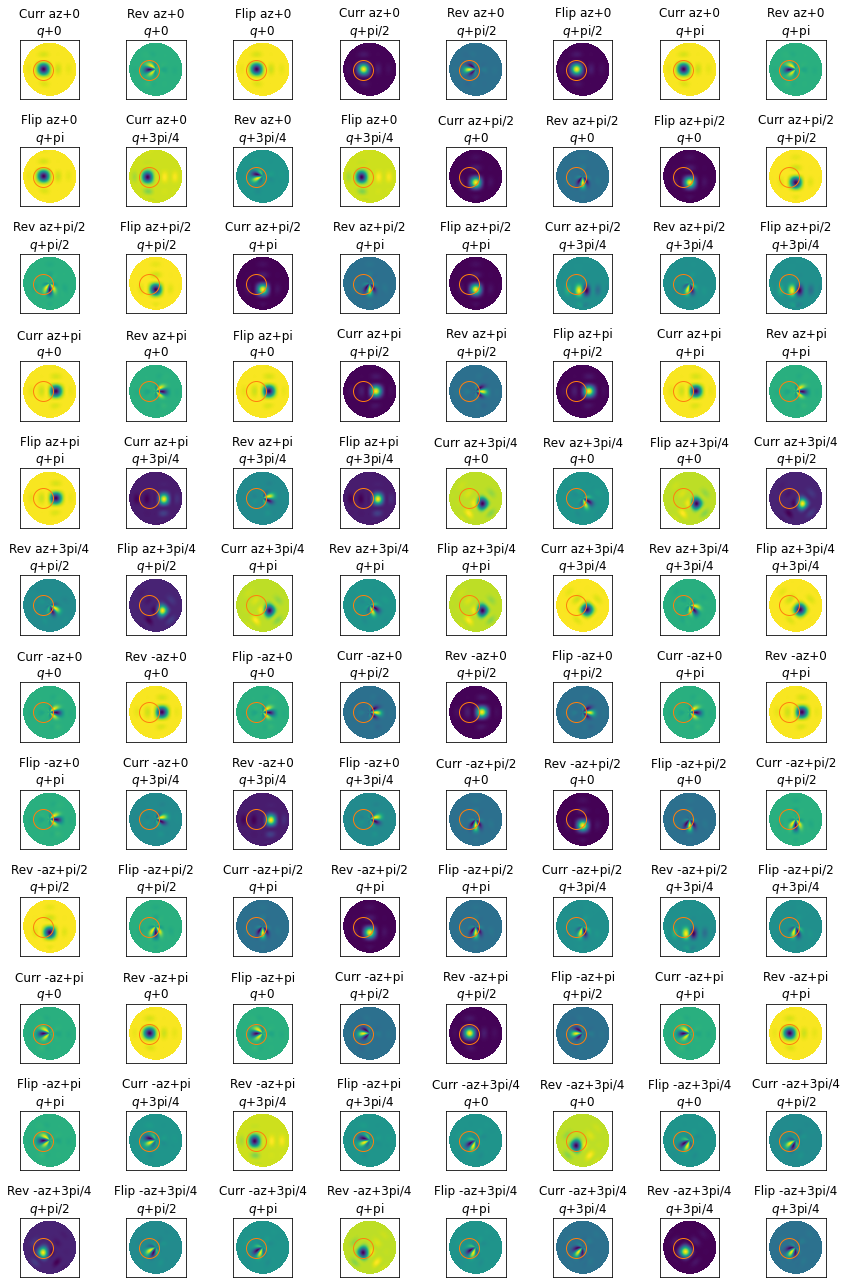

In [25]:
plot_all_combos('Q')

From that enjoyable (not) plot, we can see the following combos give a positive Q in the correct direction:

 - Current, with `az` + 0 rad offset, rotated by parallactic angle + $\pi/2$ rad
 - Flipped, with `az` + 0 rad offset, rotated by parallactic angle + $\pi/2$ rad
 - Reversed, with `-az` + $\pi$ rad offset, rotated by parallactic angle + $\pi/2$ rad

## Plot all for Stokes U
Doing the same but for the Stokes U sky, we see from the list of three correctly pointed positive Q above, only

- Flipped, with `az` + 0 rad offset, rotated by parallactic angle + $\pi/2$ rad

returns a correctly pointed positive U also.

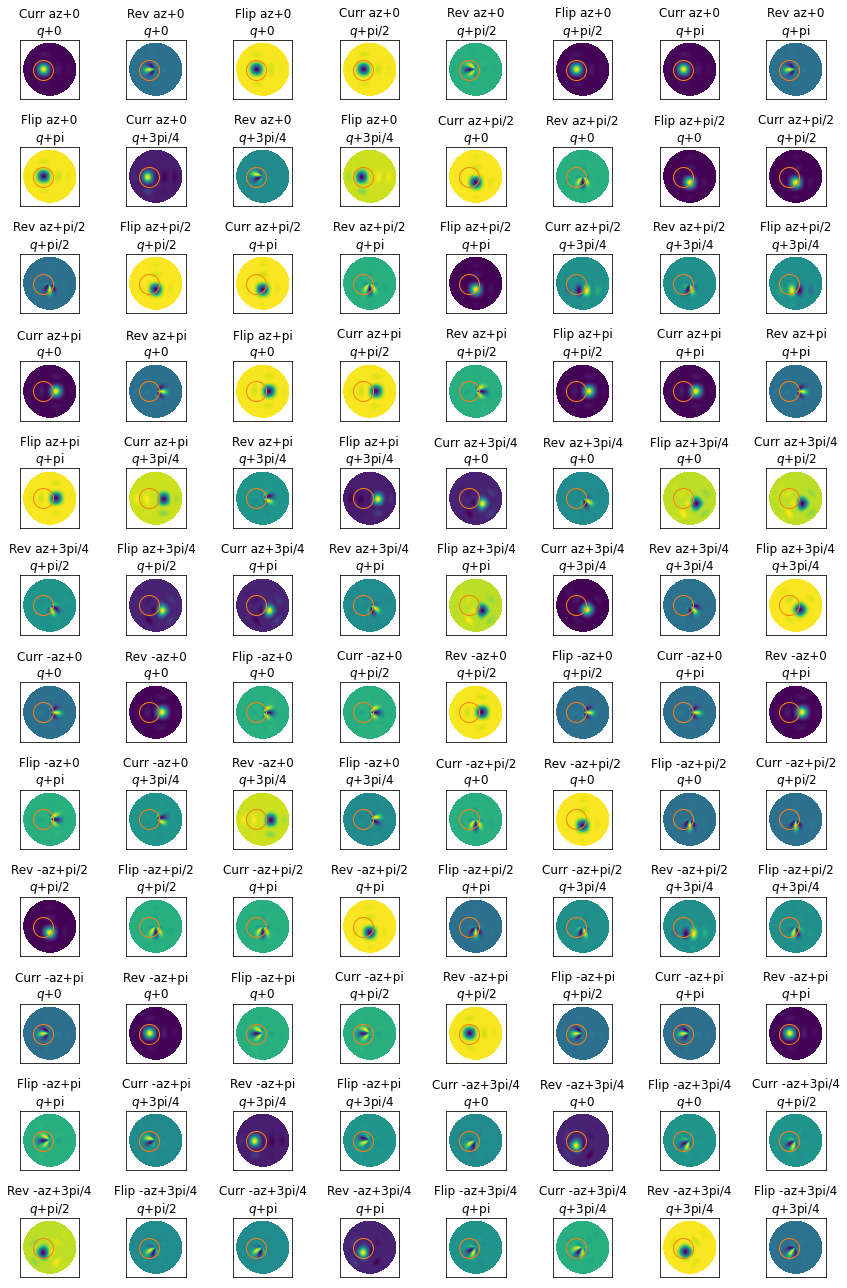

In [26]:
plot_all_combos('U')